In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

zip      City State        Metro      CountyName year-month    zri
0  1013  Chicopee    MA  Springfield  Hampden County    2014-01  928.0
1  1013  Chicopee    MA  Springfield  Hampden County    2014-02  931.0
2  1013  Chicopee    MA  Springfield  Hampden County    2014-03  934.0
3  1013  Chicopee    MA  Springfield  Hampden County    2014-04  929.0
4  1013  Chicopee    MA  Springfield  Hampden County    2014-05  929.0

In [5]:
# df = multi_data[multi_data["year-month"]=="2014-01"];
# temp = df.groupby("State")["zip"].count();
# temp = pd.DataFrame({"State": temp.index, "num_zip": temp});
# temp.reset_index(drop = True, inplace = True);

In [6]:
# temp.sort_values("num_zip", ascending = False, inplace = True);
# print(df[df["State"].isin(zone_dict["zone_6"])].shape[0])

zone_dict = {
    "zone_1": ["MA", "CT", "RI", "DC", "NJ", "ME", "NH"],
    "zone_2": ["NY"],
    "zone_3": ["FL", "GA", "NC", "TN", "SC", "KY", "MO", "AR"],
    "zone_4": ["CA", "WA", "OR", "AK", "HI"],
    "zone_5": ["TX", "CO", "AZ", "KS", "UT", "NV", "MT", "OK", "ND", "NM"],
    "zone_6": ["IL", "PA", "VA", "OH", "WI", "MD", "MN", "IN", "MI", "WV", "IA"]
};

In [7]:
# In our first try, just look at the zip codes in NY.
multi_2 = multi_data[multi_data["State"].isin(zone_dict["zone_2"])]["zip"].unique();
print(len(multi_2))

230


#### Segmenting the csv file into tens of thousands of windows

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [10]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
#for zip_num in multi_data["zip"].unique():
for zip_num in multi_2:
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [11]:
# i = 0
# for x,y in dataset:
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())
# i

In [12]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [13]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./tensorflow_ckpt/{epoch:03d}_{mse:.4f}_{val_mse:.4f}",\
#                                                  save_best_only=False,\
#                                                  save_weights_only=False, verbose=1,\
#                                                  save_freq="epoch");

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
# history = model.fit(dataset, epochs=10, validation_data=validset,\
#                     callbacks=[cp_callback])
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    history = model.fit(dataset, epochs=500, validation_data=validset);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
____________________________________________________

Epoch 43/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0087 - mae: 0.0942 - mse: 0.0174 - val_loss: 0.0179 - val_mae: 0.1170 - val_mse: 0.0365
Epoch 44/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0087 - mae: 0.0944 - mse: 0.0174 - val_loss: 0.0176 - val_mae: 0.1153 - val_mse: 0.0359
Epoch 45/500
460/460 [==============================] - 19s 41ms/step - loss: 0.0086 - mae: 0.0940 - mse: 0.0172 - val_loss: 0.0174 - val_mae: 0.1152 - val_mse: 0.0356
Epoch 46/500
460/460 [==============================] - 19s 41ms/step - loss: 0.0086 - mae: 0.0938 - mse: 0.0172 - val_loss: 0.0174 - val_mae: 0.1133 - val_mse: 0.0356
Epoch 47/500
460/460 [==============================] - 19s 41ms/step - loss: 0.0085 - mae: 0.0937 - mse: 0.0171 - val_loss: 0.0172 - val_mae: 0.1137 - val_mse: 0.0351
Epoch 48/500
460/460 [==============================] - 19s 41ms/step - loss: 0.0085 - mae: 0.0937 - mse: 0.0170 - val_loss: 0.0174 - val_mae: 0.1143 - val_mse:

Epoch 92/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0072 - mae: 0.0869 - mse: 0.0144 - val_loss: 0.0185 - val_mae: 0.1249 - val_mse: 0.0374
Epoch 93/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0071 - mae: 0.0864 - mse: 0.0142 - val_loss: 0.0189 - val_mae: 0.1271 - val_mse: 0.0383
Epoch 94/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0071 - mae: 0.0865 - mse: 0.0142 - val_loss: 0.0188 - val_mae: 0.1264 - val_mse: 0.0381
Epoch 95/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0071 - mae: 0.0862 - mse: 0.0141 - val_loss: 0.0187 - val_mae: 0.1244 - val_mse: 0.0379
Epoch 96/500
460/460 [==============================] - 18s 38ms/step - loss: 0.0070 - mae: 0.0863 - mse: 0.0141 - val_loss: 0.0189 - val_mae: 0.1265 - val_mse: 0.0382
Epoch 97/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0070 - mae: 0.0858 - mse: 0.0140 - val_loss: 0.0187 - val_mae: 0.1252 - val_mse:

460/460 [==============================] - 17s 38ms/step - loss: 0.0054 - mae: 0.0770 - mse: 0.0109 - val_loss: 0.0217 - val_mae: 0.1372 - val_mse: 0.0442
Epoch 141/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0054 - mae: 0.0767 - mse: 0.0107 - val_loss: 0.0213 - val_mae: 0.1352 - val_mse: 0.0433
Epoch 142/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0053 - mae: 0.0764 - mse: 0.0107 - val_loss: 0.0213 - val_mae: 0.1370 - val_mse: 0.0434
Epoch 143/500
460/460 [==============================] - 17s 37ms/step - loss: 0.0053 - mae: 0.0760 - mse: 0.0105 - val_loss: 0.0217 - val_mae: 0.1382 - val_mse: 0.0440
Epoch 144/500
460/460 [==============================] - 17s 37ms/step - loss: 0.0052 - mae: 0.0758 - mse: 0.0105 - val_loss: 0.0219 - val_mae: 0.1398 - val_mse: 0.0444
Epoch 145/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0052 - mae: 0.0760 - mse: 0.0105 - val_loss: 0.0218 - val_mae: 0.1386 - val_mse: 0.0444


460/460 [==============================] - 18s 38ms/step - loss: 0.0040 - mae: 0.0671 - mse: 0.0080 - val_loss: 0.0238 - val_mae: 0.1470 - val_mse: 0.0483
Epoch 189/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0039 - mae: 0.0670 - mse: 0.0079 - val_loss: 0.0256 - val_mae: 0.1565 - val_mse: 0.0520
Epoch 190/500
460/460 [==============================] - 18s 38ms/step - loss: 0.0039 - mae: 0.0667 - mse: 0.0078 - val_loss: 0.0248 - val_mae: 0.1529 - val_mse: 0.0503
Epoch 191/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0039 - mae: 0.0668 - mse: 0.0079 - val_loss: 0.0251 - val_mae: 0.1534 - val_mse: 0.0510
Epoch 192/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0040 - mae: 0.0674 - mse: 0.0080 - val_loss: 0.0254 - val_mae: 0.1550 - val_mse: 0.0516
Epoch 193/500
460/460 [==============================] - 18s 38ms/step - loss: 0.0041 - mae: 0.0680 - mse: 0.0081 - val_loss: 0.0249 - val_mae: 0.1552 - val_mse: 0.0506


460/460 [==============================] - 18s 39ms/step - loss: 0.0032 - mae: 0.0613 - mse: 0.0064 - val_loss: 0.0266 - val_mae: 0.1593 - val_mse: 0.0540
Epoch 237/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0032 - mae: 0.0607 - mse: 0.0064 - val_loss: 0.0260 - val_mae: 0.1563 - val_mse: 0.0528
Epoch 238/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0032 - mae: 0.0608 - mse: 0.0064 - val_loss: 0.0265 - val_mae: 0.1587 - val_mse: 0.0539
Epoch 239/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0031 - mae: 0.0606 - mse: 0.0063 - val_loss: 0.0270 - val_mae: 0.1600 - val_mse: 0.0548
Epoch 240/500
460/460 [==============================] - 17s 36ms/step - loss: 0.0032 - mae: 0.0608 - mse: 0.0064 - val_loss: 0.0263 - val_mae: 0.1571 - val_mse: 0.0535
Epoch 241/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0032 - mae: 0.0609 - mse: 0.0064 - val_loss: 0.0262 - val_mae: 0.1567 - val_mse: 0.0533


460/460 [==============================] - 19s 41ms/step - loss: 0.0026 - mae: 0.0553 - mse: 0.0053 - val_loss: 0.0263 - val_mae: 0.1570 - val_mse: 0.0537
Epoch 285/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0026 - mae: 0.0548 - mse: 0.0052 - val_loss: 0.0261 - val_mae: 0.1548 - val_mse: 0.0532
Epoch 286/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0026 - mae: 0.0556 - mse: 0.0053 - val_loss: 0.0263 - val_mae: 0.1554 - val_mse: 0.0536
Epoch 287/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0028 - mae: 0.0576 - mse: 0.0057 - val_loss: 0.0262 - val_mae: 0.1551 - val_mse: 0.0535
Epoch 288/500
460/460 [==============================] - 17s 38ms/step - loss: 0.0027 - mae: 0.0564 - mse: 0.0054 - val_loss: 0.0263 - val_mae: 0.1560 - val_mse: 0.0537
Epoch 289/500
460/460 [==============================] - 19s 42ms/step - loss: 0.0027 - mae: 0.0563 - mse: 0.0054 - val_loss: 0.0264 - val_mae: 0.1562 - val_mse: 0.0538


460/460 [==============================] - 18s 39ms/step - loss: 0.0024 - mae: 0.0528 - mse: 0.0047 - val_loss: 0.0258 - val_mae: 0.1537 - val_mse: 0.0529
Epoch 333/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0024 - mae: 0.0532 - mse: 0.0048 - val_loss: 0.0255 - val_mae: 0.1519 - val_mse: 0.0521
Epoch 334/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0023 - mae: 0.0521 - mse: 0.0046 - val_loss: 0.0246 - val_mae: 0.1488 - val_mse: 0.0503
Epoch 335/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0022 - mae: 0.0514 - mse: 0.0045 - val_loss: 0.0254 - val_mae: 0.1527 - val_mse: 0.0518
Epoch 336/500
460/460 [==============================] - 18s 39ms/step - loss: 0.0022 - mae: 0.0511 - mse: 0.0045 - val_loss: 0.0256 - val_mae: 0.1522 - val_mse: 0.0524
Epoch 337/500
460/460 [==============================] - 18s 40ms/step - loss: 0.0023 - mae: 0.0525 - mse: 0.0047 - val_loss: 0.0252 - val_mae: 0.1512 - val_mse: 0.0517


460/460 [==============================] - 16s 35ms/step - loss: 0.0020 - mae: 0.0479 - mse: 0.0039 - val_loss: 0.0247 - val_mae: 0.1532 - val_mse: 0.0502
Epoch 381/500
460/460 [==============================] - 16s 34ms/step - loss: 0.0020 - mae: 0.0481 - mse: 0.0039 - val_loss: 0.0248 - val_mae: 0.1509 - val_mse: 0.0505
Epoch 382/500
460/460 [==============================] - 16s 34ms/step - loss: 0.0020 - mae: 0.0488 - mse: 0.0040 - val_loss: 0.0248 - val_mae: 0.1530 - val_mse: 0.0505
Epoch 383/500
460/460 [==============================] - 17s 36ms/step - loss: 0.0020 - mae: 0.0483 - mse: 0.0040 - val_loss: 0.0244 - val_mae: 0.1507 - val_mse: 0.0498
Epoch 384/500
460/460 [==============================] - 18s 38ms/step - loss: 0.0019 - mae: 0.0475 - mse: 0.0039 - val_loss: 0.0252 - val_mae: 0.1552 - val_mse: 0.0513
Epoch 385/500
460/460 [==============================] - 17s 37ms/step - loss: 0.0020 - mae: 0.0479 - mse: 0.0039 - val_loss: 0.0249 - val_mae: 0.1542 - val_mse: 0.0507


460/460 [==============================] - 16s 34ms/step - loss: 0.0018 - mae: 0.0464 - mse: 0.0037 - val_loss: 0.0252 - val_mae: 0.1540 - val_mse: 0.0513
Epoch 429/500
460/460 [==============================] - 15s 33ms/step - loss: 0.0017 - mae: 0.0452 - mse: 0.0035 - val_loss: 0.0251 - val_mae: 0.1529 - val_mse: 0.0512
Epoch 430/500
460/460 [==============================] - 15s 32ms/step - loss: 0.0018 - mae: 0.0458 - mse: 0.0036 - val_loss: 0.0259 - val_mae: 0.1571 - val_mse: 0.0528
Epoch 431/500
460/460 [==============================] - 15s 33ms/step - loss: 0.0019 - mae: 0.0471 - mse: 0.0038 - val_loss: 0.0253 - val_mae: 0.1529 - val_mse: 0.0517
Epoch 432/500
460/460 [==============================] - 15s 34ms/step - loss: 0.0018 - mae: 0.0457 - mse: 0.0036 - val_loss: 0.0251 - val_mae: 0.1538 - val_mse: 0.0510 - los
Epoch 433/500
460/460 [==============================] - 15s 34ms/step - loss: 0.0017 - mae: 0.0452 - mse: 0.0035 - val_loss: 0.0250 - val_mae: 0.1518 - val_mse: 0

460/460 [==============================] - 14s 31ms/step - loss: 0.0016 - mae: 0.0441 - mse: 0.0033 - val_loss: 0.0259 - val_mae: 0.1547 - val_mse: 0.0527
Epoch 477/500
460/460 [==============================] - 14s 31ms/step - loss: 0.0017 - mae: 0.0448 - mse: 0.0034 - val_loss: 0.0255 - val_mae: 0.1526 - val_mse: 0.0519
Epoch 478/500
460/460 [==============================] - 15s 32ms/step - loss: 0.0017 - mae: 0.0442 - mse: 0.0033 - val_loss: 0.0257 - val_mae: 0.1543 - val_mse: 0.0523
Epoch 479/500
460/460 [==============================] - 15s 32ms/step - loss: 0.0018 - mae: 0.0465 - mse: 0.0037 - val_loss: 0.0249 - val_mae: 0.1519 - val_mse: 0.0507
Epoch 480/500
460/460 [==============================] - 15s 32ms/step - loss: 0.0017 - mae: 0.0450 - mse: 0.0034 - val_loss: 0.0250 - val_mae: 0.1517 - val_mse: 0.0508
Epoch 481/500
460/460 [==============================] - 14s 31ms/step - loss: 0.0017 - mae: 0.0447 - mse: 0.0034 - val_loss: 0.0249 - val_mae: 0.1518 - val_mse: 0.0506


#### Prediction, checking results

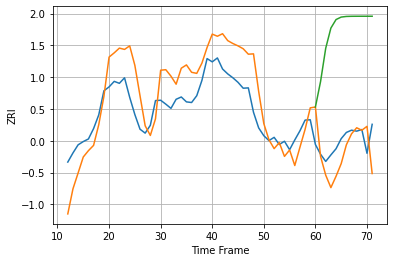

10001 87.09915140983445 76.17841179264535 343.6095367126124


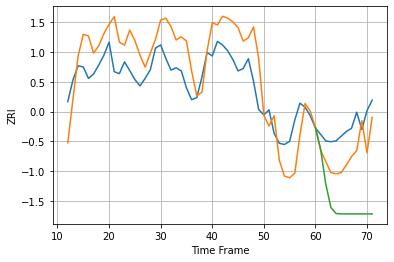

10002 77.98685507968592 71.76505295319924 198.07564985693293


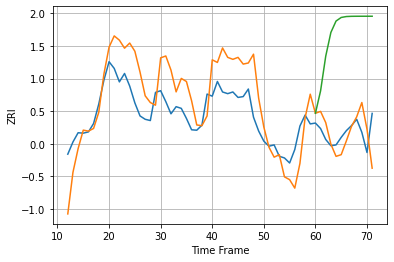

10003 72.09685467558434 51.623971217143605 245.8023349046773


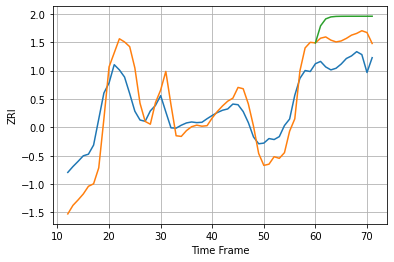

10005 73.82100249208578 76.90411306797739 133.76808529933962


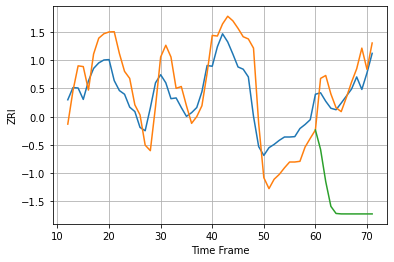

10009 76.15040912594995 51.77959194232368 306.35836306944935


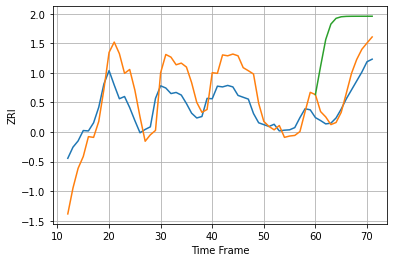

10010 69.90446487021718 41.46036355187423 194.78363716039928


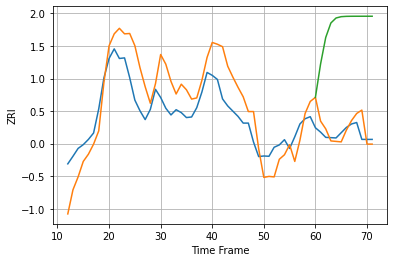

10011 94.92513451049976 46.81235496788828 367.44079061827136


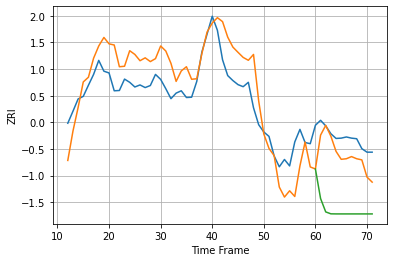

10012 92.17594490170809 73.96944337831248 246.85086672371128


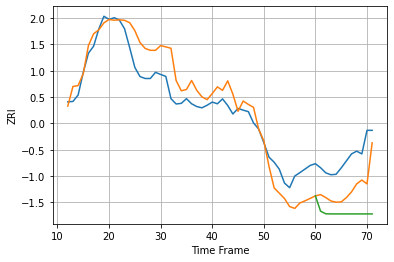

10013 95.54985808100025 152.2524685121012 263.94471935825703


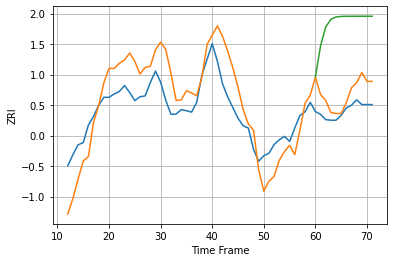

10014 97.93093400785209 71.46460861107454 312.95777590010096


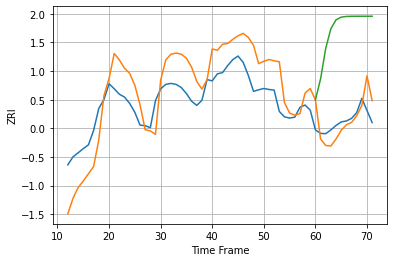

10016 87.70016608638542 52.54204290523816 288.4037721382502


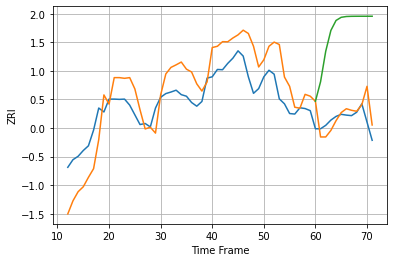

10017 101.72592114086133 56.788351377222 344.7725973985637


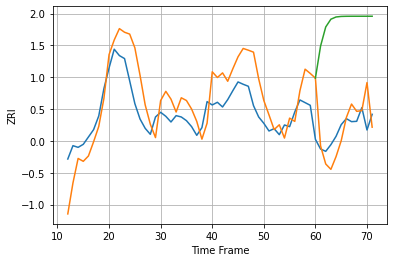

10018 78.99641873157017 77.5180438181469 317.9158301073954


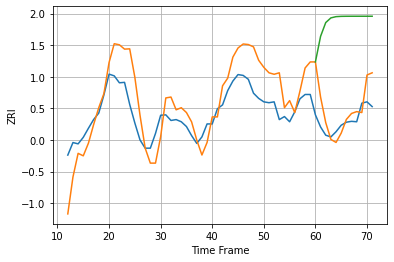

10019 61.20857589114249 52.32243618632136 230.36890992499934


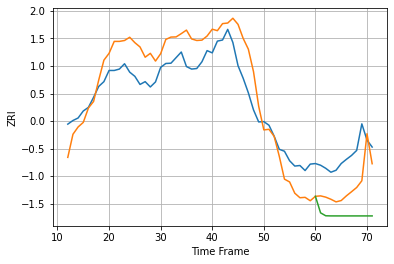

10021 89.42221775490852 120.09833869345587 212.76297455206566


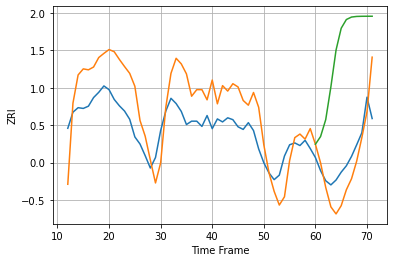

10022 87.92760913556575 70.52074210290834 288.35450684988797


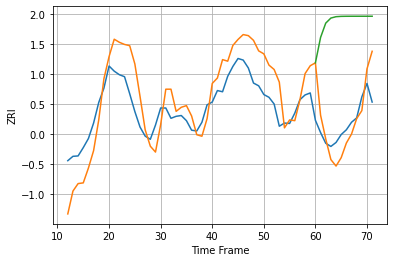

10023 67.62502912315924 65.91299048317153 258.5668503372863


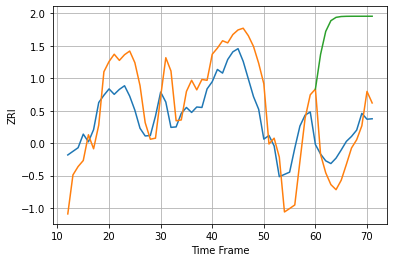

10024 69.23747180639556 55.31932941969462 256.4057713746016


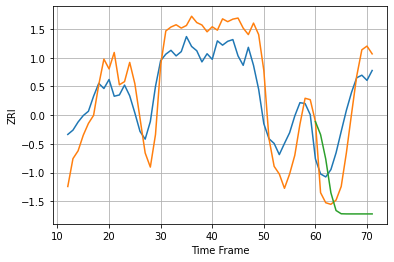

10025 68.46657515947996 77.4333890229443 228.65000542747364


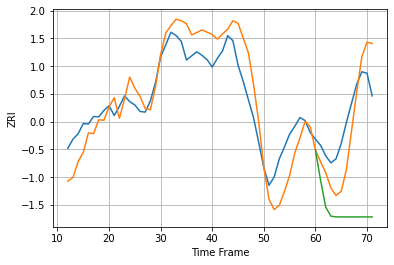

10027 72.02550362632407 93.04327508663803 284.5131656119207


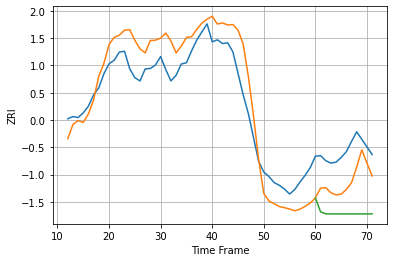

10028 96.77452386658511 127.13699198591424 247.52034907009224


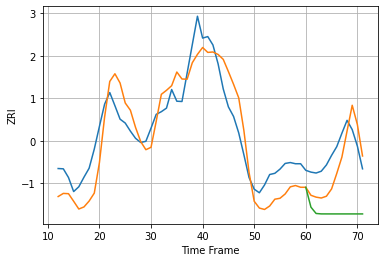

10029 79.0419444298355 79.88315847034859 203.14092475509761


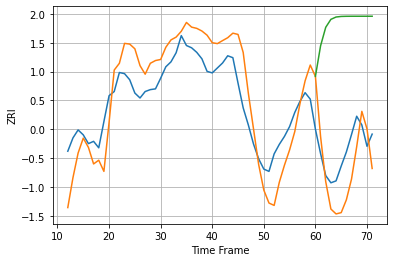

10031 75.95307157644154 89.59569585182776 337.2213302356144


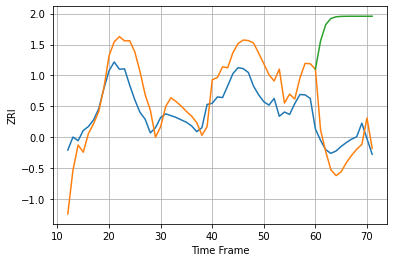

10036 87.72871554232516 79.7005615137538 398.3408251074546


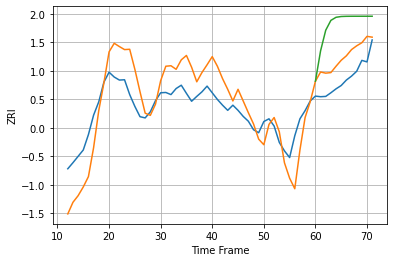

10038 86.58834972599696 72.86444425336983 183.68194442367056


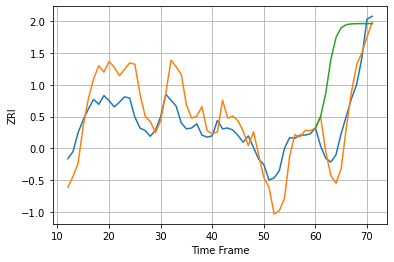

10065 60.38309126836821 44.44722509550782 169.39754937688022


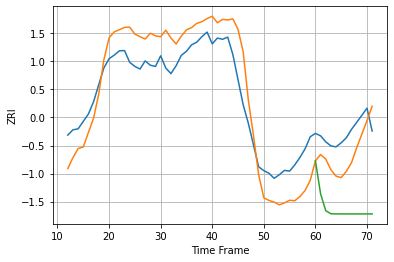

10075 115.86103436367556 107.79308169415147 322.8683030067238


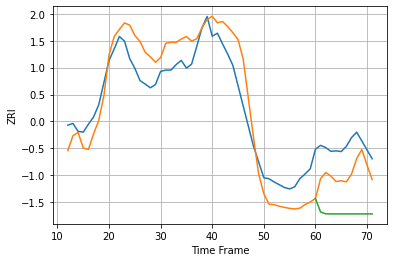

10128 96.25919127353139 119.13876580836497 265.5502121950762


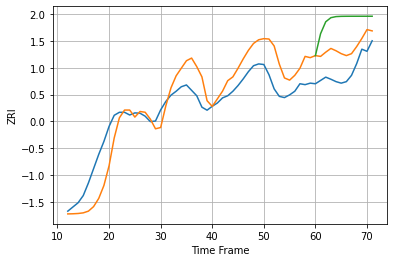

10302 73.4174825377714 79.73658846377883 170.38299273922885


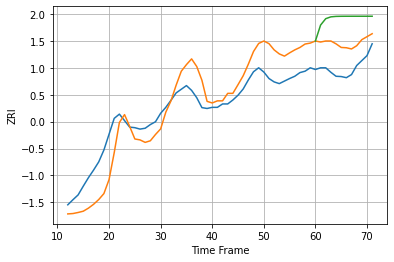

10303 79.97167858296659 90.90808975097292 174.68461775045782


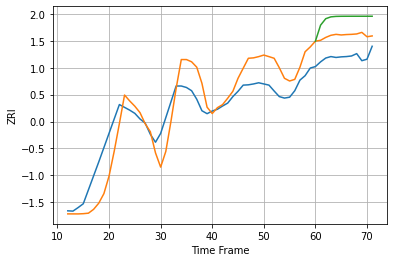

10304 76.32452107961845 74.39789894790748 130.7568472260966


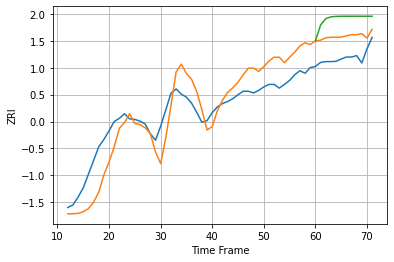

10305 76.95206569589844 77.10130164288935 137.10688439589177


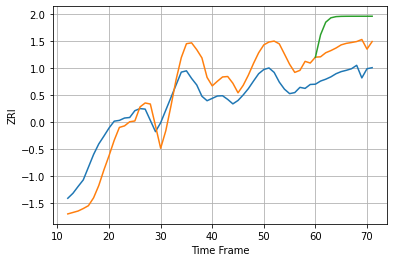

10306 90.5907434171502 102.14821601972976 200.6417700003965


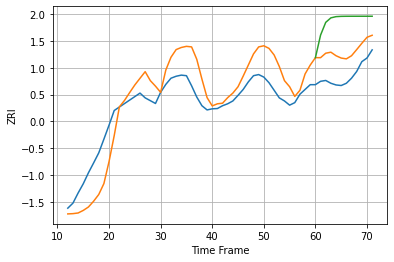

10310 82.70459824347502 87.0394825487382 195.9315885391634


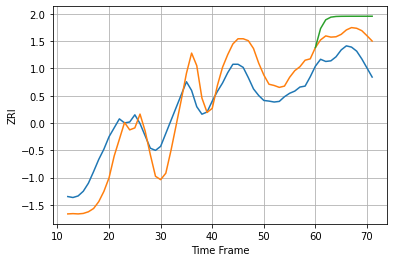

10312 78.24574729317486 76.70861036960898 127.34139940746871


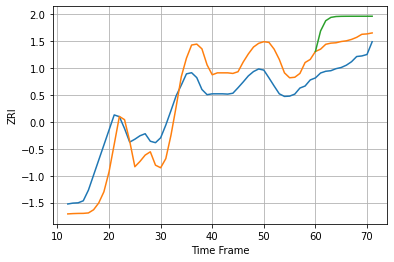

10314 86.98176172072672 80.68995352325763 151.35263290258226


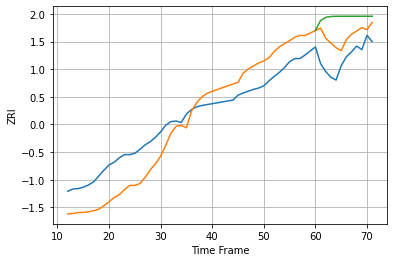

10453 53.16058202307607 53.24849842471168 94.06824199134557


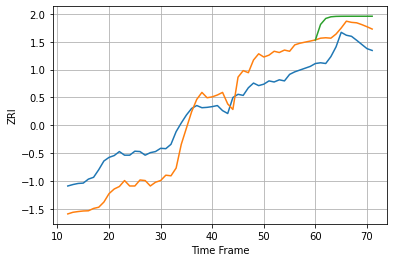

10455 73.43718591246139 52.70212483719737 84.25623349875897


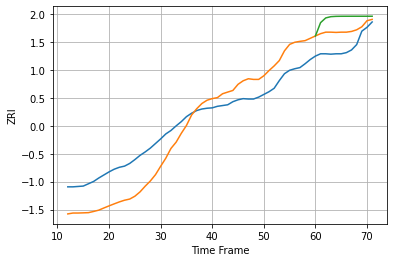

10456 63.37930834090191 46.02130334943327 77.21929533248272


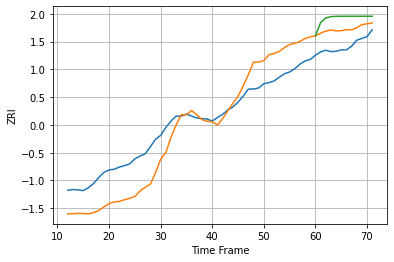

10457 67.57876078720257 48.50215934900408 79.19521713774085


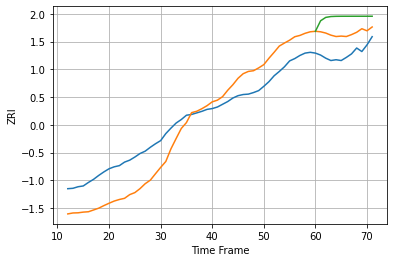

10458 61.896775478036844 53.763658718007754 92.55787162546531


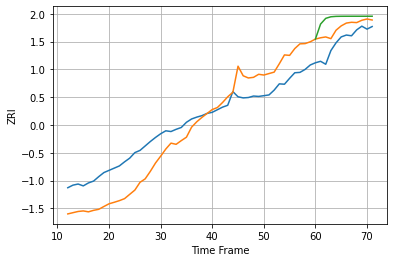

10459 65.29652210236391 41.62823940513021 68.14528256104335


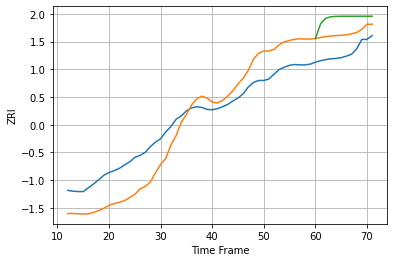

10460 64.25034876995385 52.40712425043124 91.13747335998498


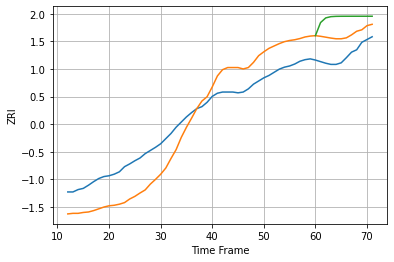

10461 64.64640806753363 53.63938551632275 94.49300036454522


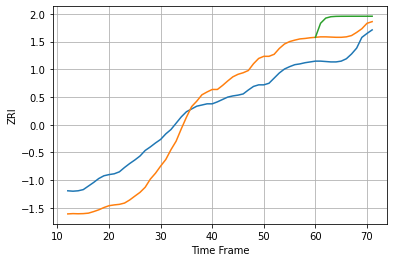

10462 63.02073501788527 50.93882860331813 90.01116836444795


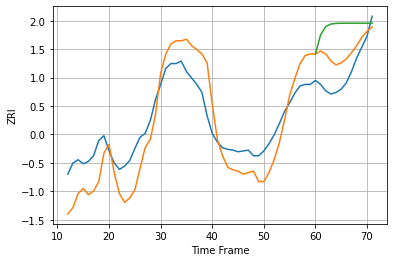

10463 33.71137506394574 30.196693622656166 61.49070293079236


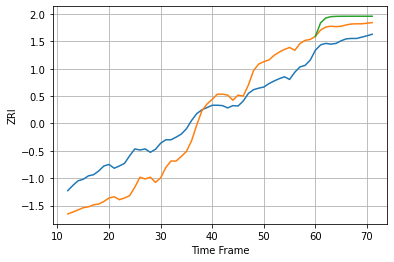

10465 66.32862855942773 38.628624226048395 59.13968650346882


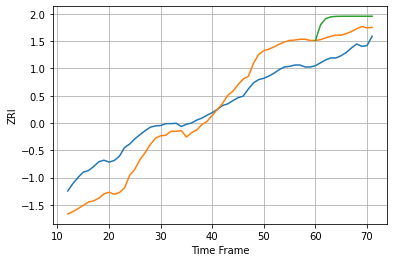

10466 71.85842651556821 61.16096740792952 105.49951546720017


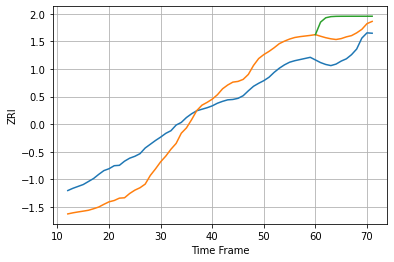

10467 64.51018315070705 55.77649524615586 98.69499980059094


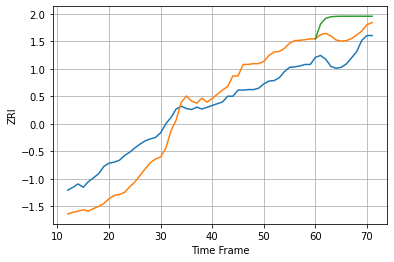

10468 51.49477483202364 44.84535416801826 80.18928214377738


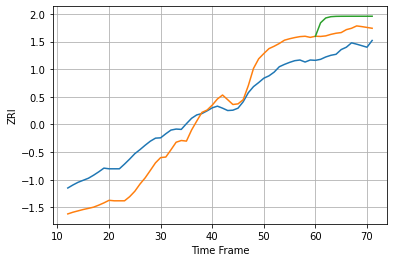

10469 71.27923744309986 57.34780604327202 95.18761865071356


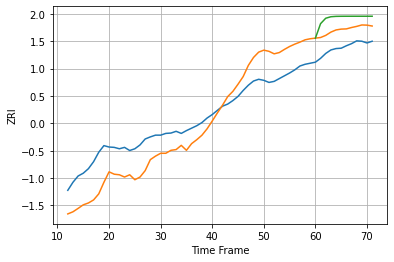

10470 69.88806024400711 51.866107284636506 84.2049005086752


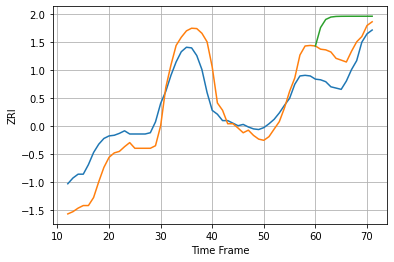

10471 35.43031996923245 38.46180907642044 82.50142337117931


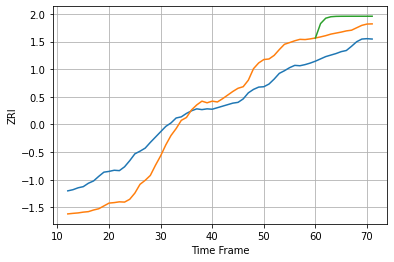

10472 62.31573848205705 48.87305723846123 81.63410756690865


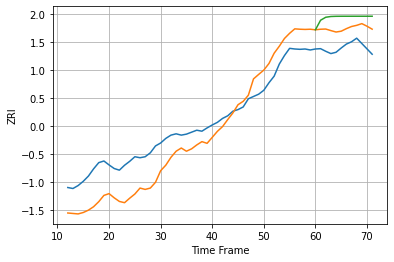

10473 73.94174101964984 60.01532827907352 93.17418035459315


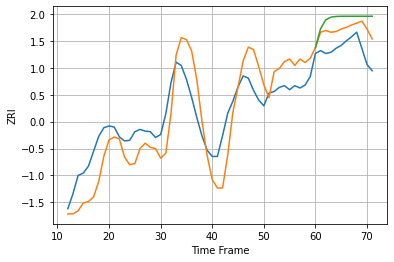

10528 47.67179197869107 36.361585289172176 55.74813694916037


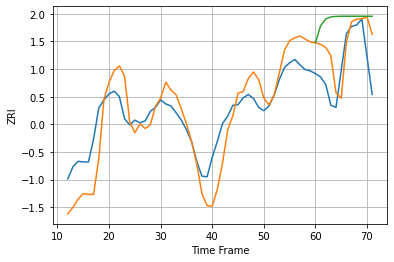

10543 37.434587602637954 47.137508098267965 80.2236760936437


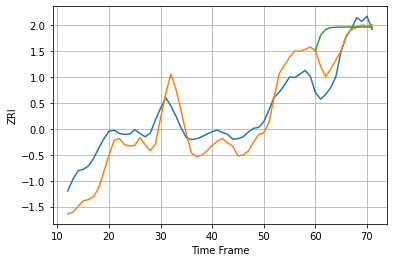

10562 43.52280779807566 38.787952991168495 79.74841497141716


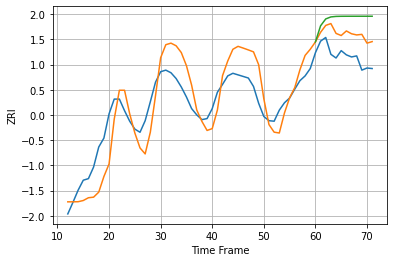

10573 43.98164202230421 43.47280857702649 73.61968158886825


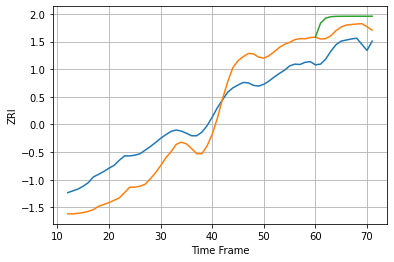

10701 72.0212940859128 51.9689428801188 83.62217890021967


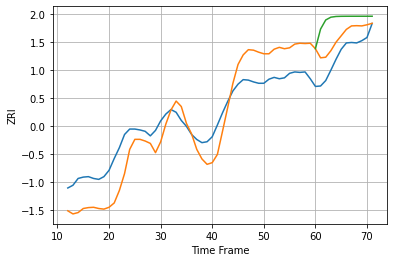

10703 56.27768008151581 43.89042441655612 83.68339232353638


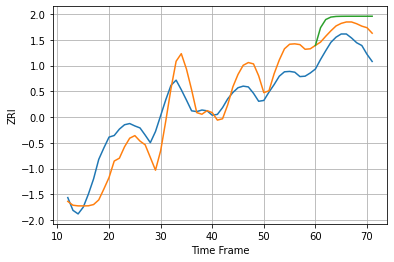

10704 54.63583294861677 46.34078805269781 71.65566358320696


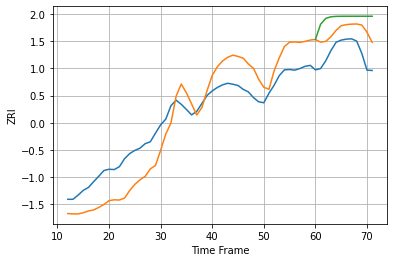

10705 77.21924283675787 71.64862142996554 114.0775934585306


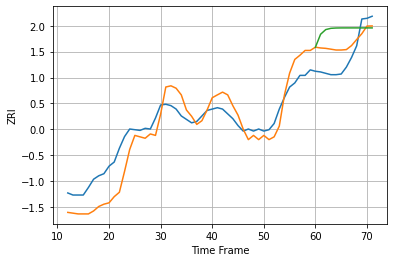

10940 27.87112421713093 28.073201098936792 48.606802599976945


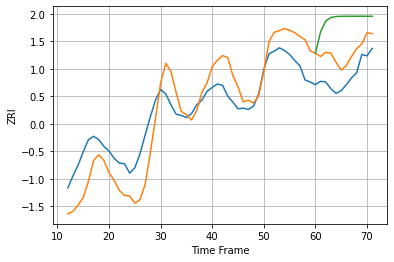

10960 38.90130749226484 37.09388778905468 85.49169648935126


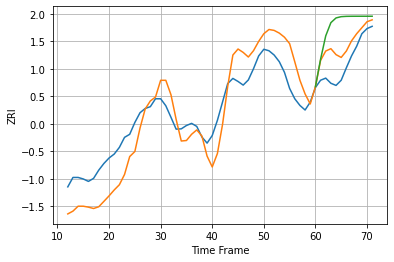

10977 83.80545231684904 64.30666620089073 134.99799783906508


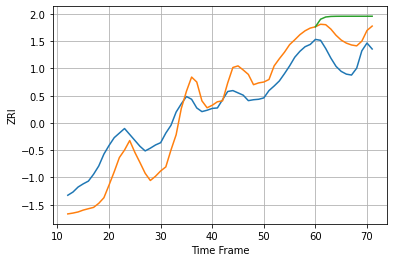

11001 49.84969714132182 52.513105242700426 92.35547873476992


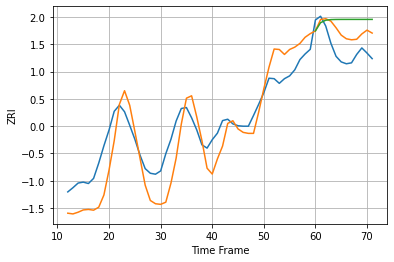

11003 53.65962058462404 43.65990014356082 69.25001913789204


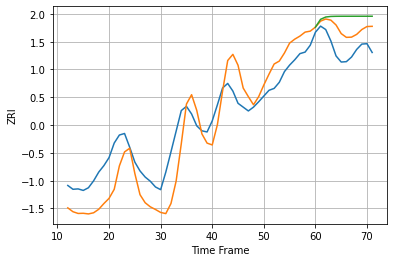

11010 67.5864323813147 52.16448278982391 83.35111144657256


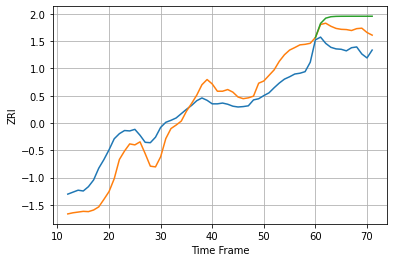

11050 53.942006008653884 49.07696683202531 78.35869971125025


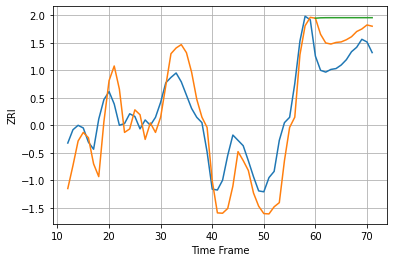

11101 31.093596298621144 28.020967275784425 46.88787103696051


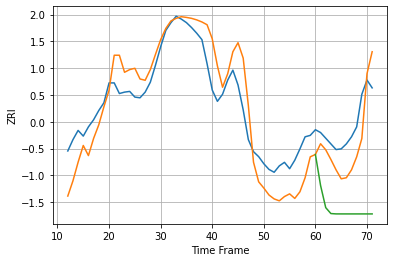

11102 37.68101547560184 38.306140547522396 120.75970728319926


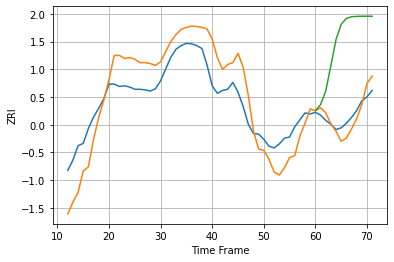

11103 45.72540472882159 16.73525304796923 135.1085334414106


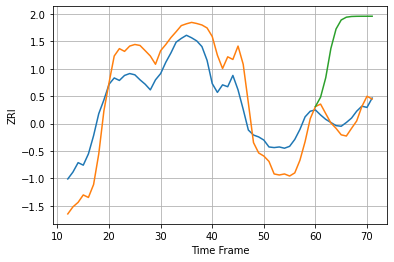

11104 44.93813614165619 12.628755817016161 131.50227256444998


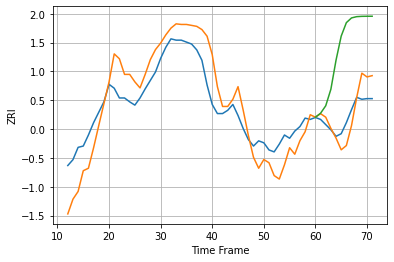

11105 37.99733216082076 23.545158008174997 111.30473130922566


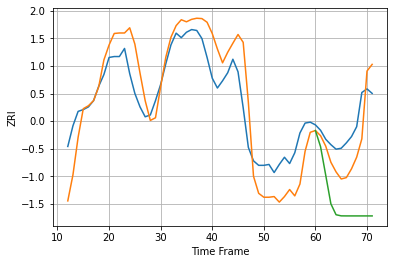

11106 32.66121166726112 29.352188465648652 90.76266952045025


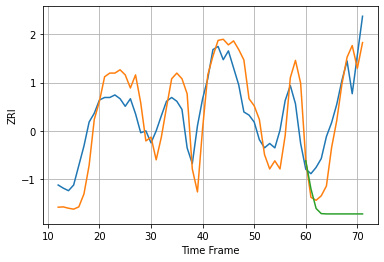

11201 46.19556466275808 45.024626477307564 178.30577001108435


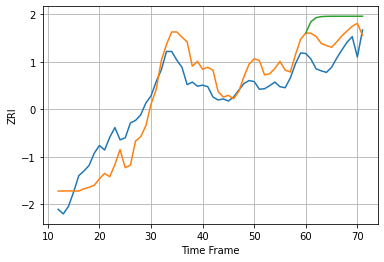

11203 41.79086610248602 43.30553468383481 77.81481916804185


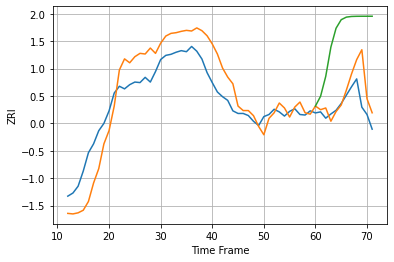

11204 44.10383272320896 37.36847486647535 141.58385911133536


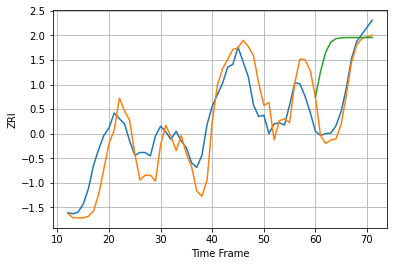

11205 42.76149259557781 22.906710170441553 96.38207211072223


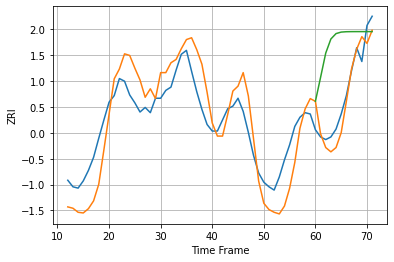

11206 41.235205447694554 23.969455448433994 92.61098716336905


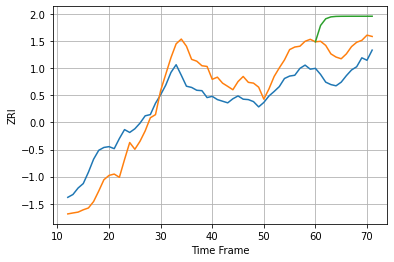

11207 58.825604420530276 64.49599557649977 132.4770461025811


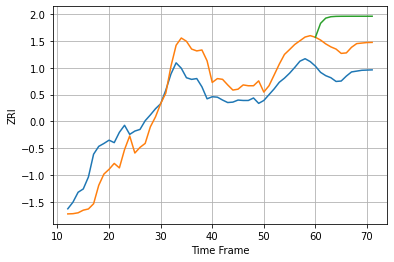

11208 55.51028073764604 69.14564389143258 134.46182672019046


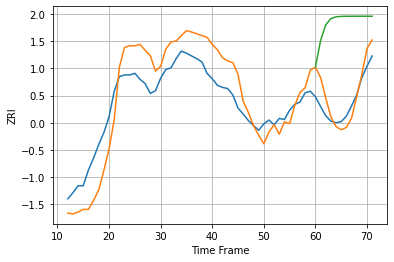

11209 46.566393900900195 29.064088785748027 148.8260005154954


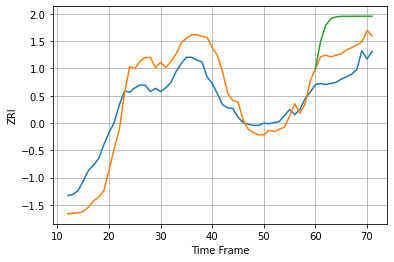

11210 43.169434961618876 44.6513782322872 95.09505367636234


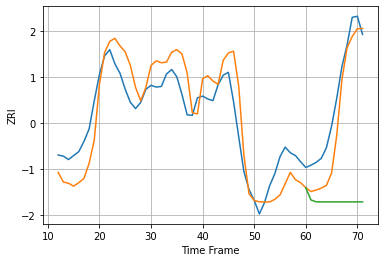

11211 45.09464671688684 46.957890151283664 206.3591578370349


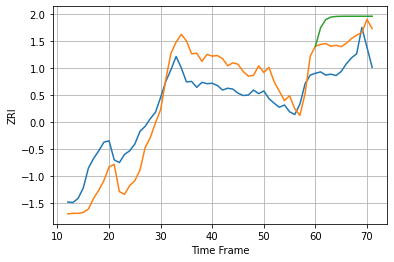

11212 56.617323220563954 57.8197435730624 99.979275577922


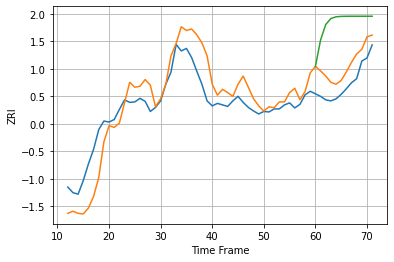

11213 42.50229215227584 39.28629913701773 124.51771004358073


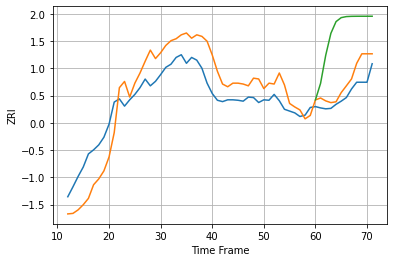

11214 53.59373048229032 32.84091939120314 143.3688820176572


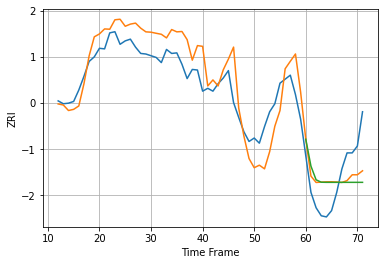

11215 40.13756824188782 51.061382609260384 57.97617647382737


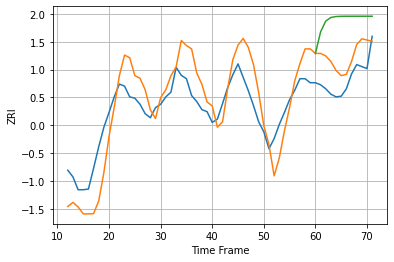

11216 39.89765337732156 37.12101505546766 89.54893739376969


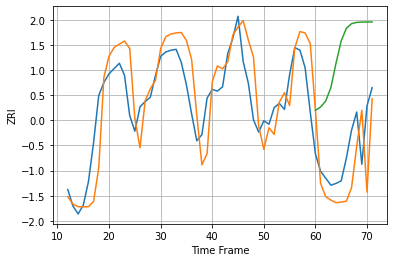

11217 36.02470157138601 47.146580302850566 116.48068326504516


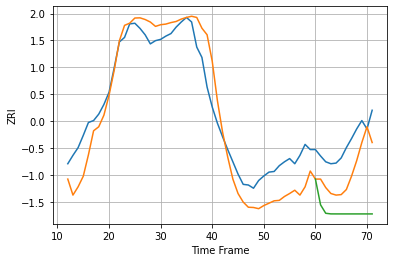

11218 38.059713973172606 47.048977363989835 107.98978196121705


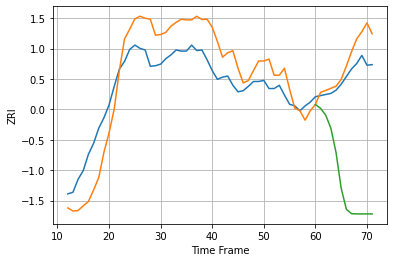

11219 51.68443670791744 35.53694968097041 204.01645010103422


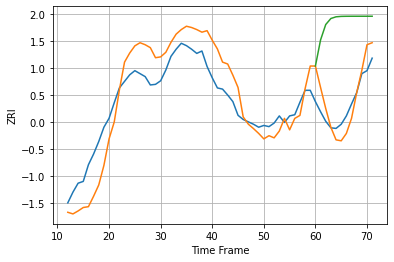

11220 40.316804638301626 30.124174824462276 139.93876382538747


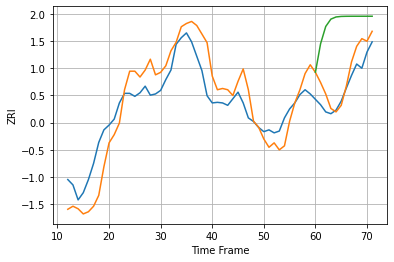

11221 38.946690620507546 27.279016934274306 110.11110595185684


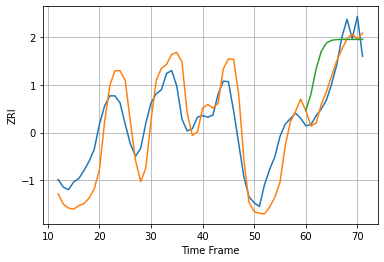

11222 53.716259923844525 25.956830820197567 66.69583611421967


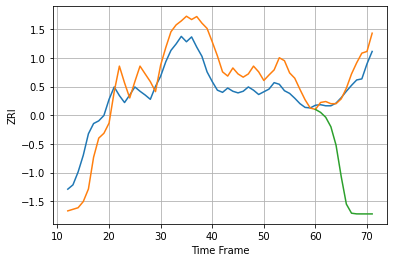

11223 44.573889379992266 21.66181921689189 188.05228517229833


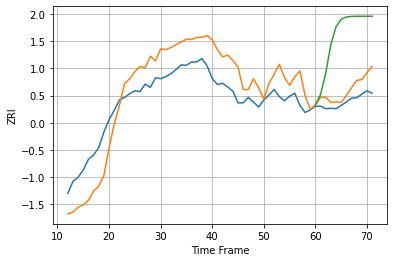

11224 61.915052303949814 31.09407994537558 166.1926478379768


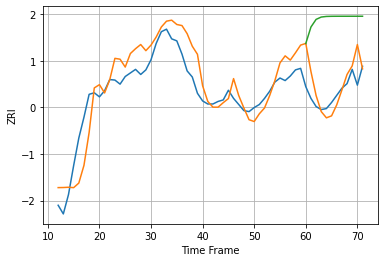

11225 39.73400673593645 39.40618173795143 144.70782845095525


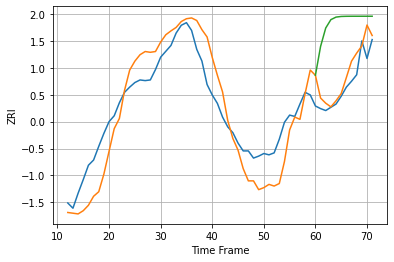

11226 39.2165311393498 25.277164879273247 97.97142349583082


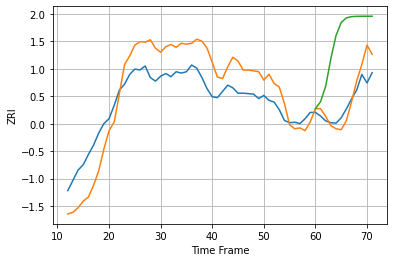

11228 58.734855125946716 31.403997778971913 149.87922229502706


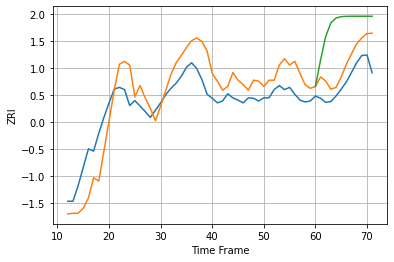

11229 52.714172957657425 43.5234727397962 125.59542159643401


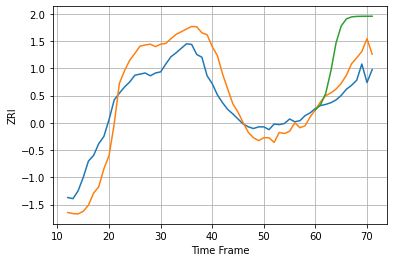

11230 41.632125346134245 32.29226780359206 92.6695154208696


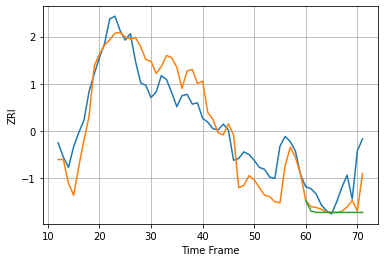

11231 36.68834876934416 37.97481679217032 50.194569961444635


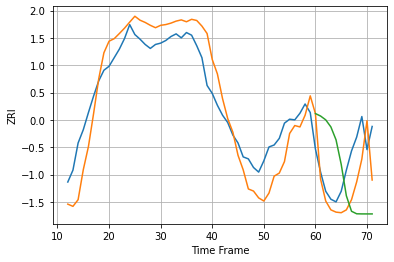

11232 38.27943599503742 50.80122281709802 98.32013178386627


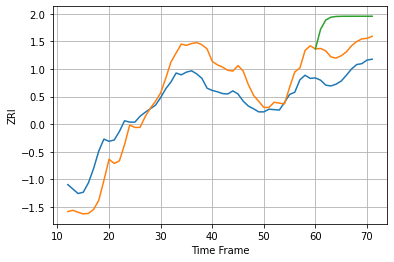

11233 52.473653956581366 59.30369779851958 122.32490837487946


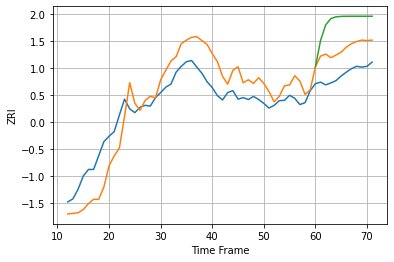

11234 59.9536455715908 64.74790356351308 135.66135746768


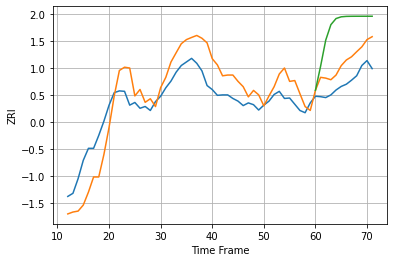

11235 51.94154465035193 46.727637031760324 127.21276059814855


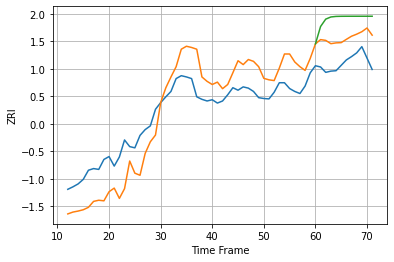

11236 64.48582133826099 61.4130073943174 106.98634459833603


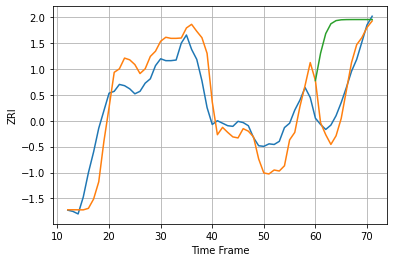

11237 38.70706204027273 24.551416524116963 104.49557431282749


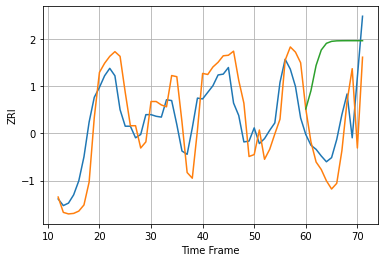

11238 33.88700400721808 45.69356319929735 98.02255612059129


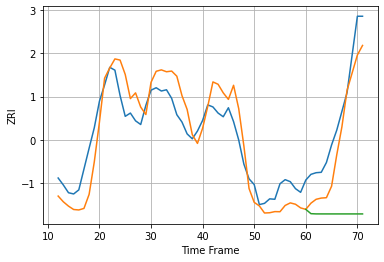

11249 54.849421693379185 69.05241366397485 272.78401998262507


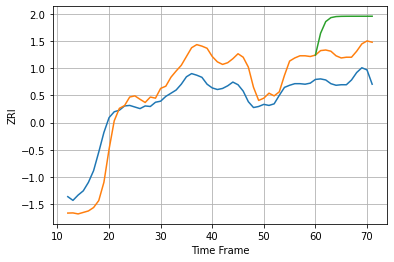

11354 44.19143719140014 53.95352031423132 111.40326615589534


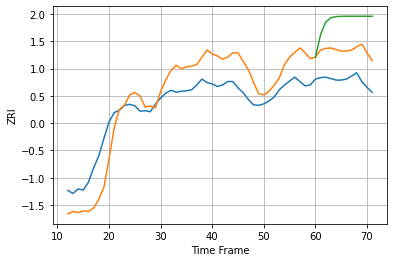

11355 49.97335816212424 60.874802714401845 123.0777704772622


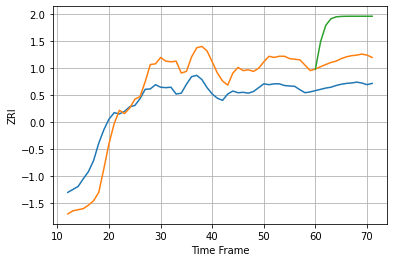

11356 59.39731674427229 60.740167041862605 148.56114447189276


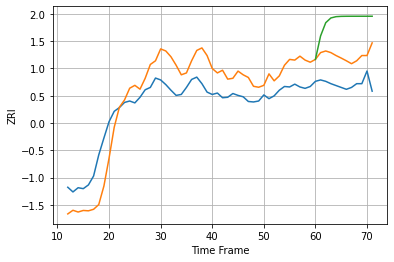

11357 53.24493160721369 62.019035308263035 135.05292407533634


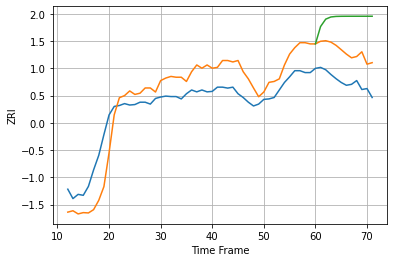

11358 48.941765718922795 63.93235743236823 133.28474763839012


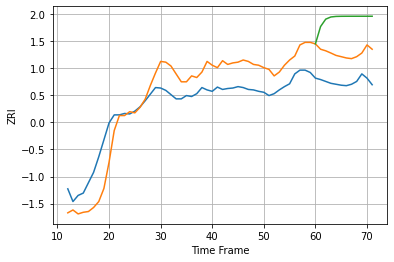

11360 50.52305694705446 62.58842503421137 133.07281712848214


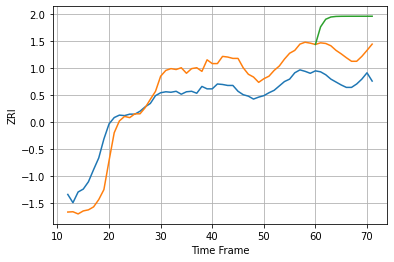

11361 48.16034898422765 59.514701923940656 125.5138920860847


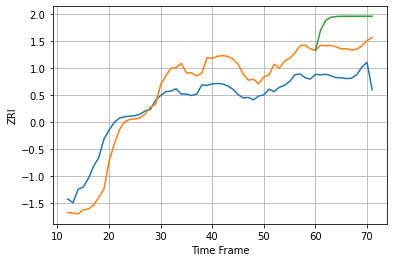

11364 48.75618497189319 62.714734346724825 116.31001048293106


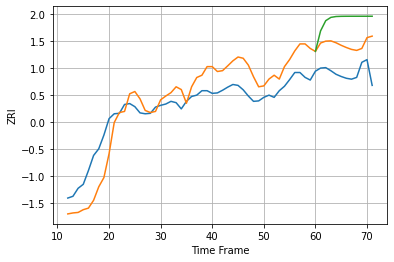

11365 50.09750980250106 65.84789871182643 120.19426372728849


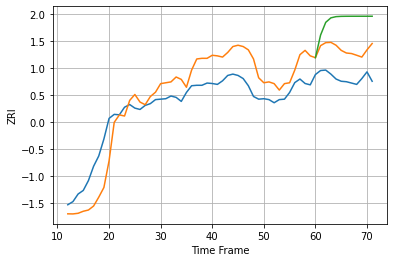

11366 52.35385574694952 63.45636142516511 128.53408538811982


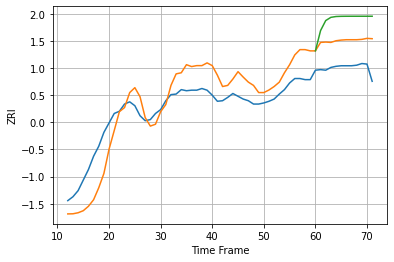

11367 39.16118758079529 49.087815791355396 86.8005238294894


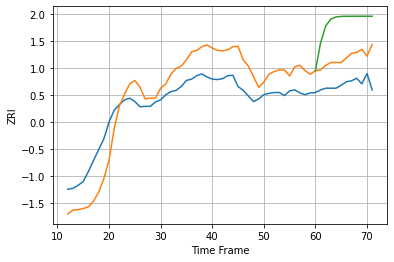

11368 57.54180471667866 62.62353136301463 144.6265282499621


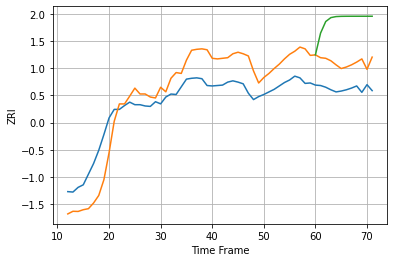

11369 58.949447220762984 63.23319655769463 160.15030085827723


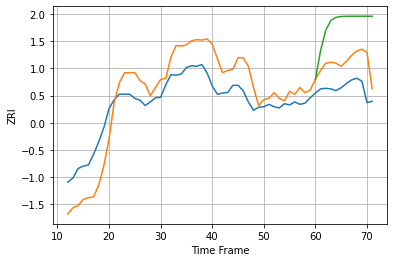

11370 41.38232494775445 45.04241810236554 110.22861846260241


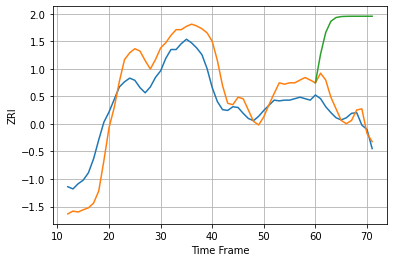

11372 32.61105706447031 18.65542961293469 129.25675119963535


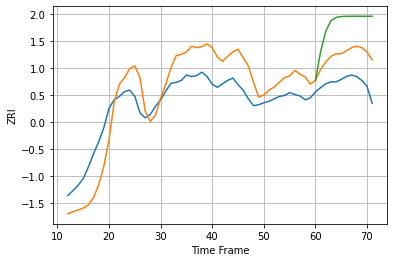

11373 51.197807069679406 58.008922996888636 123.75036313332758


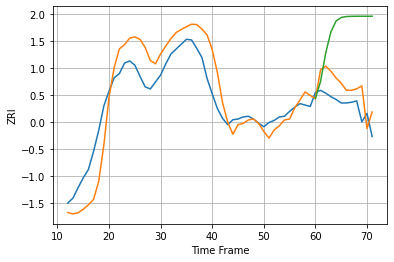

11374 33.18430191433307 29.917672760590225 114.05641113703304


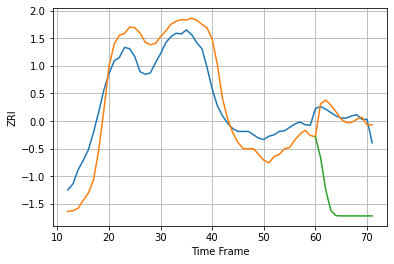

11375 36.74401443186463 16.059380423401528 130.77983329541073


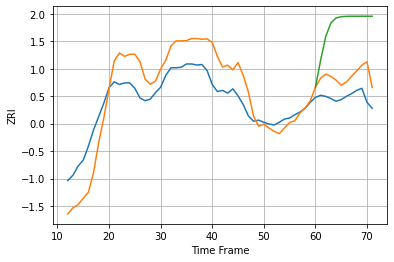

11377 46.1219950734725 39.76414296347767 134.58738065577563


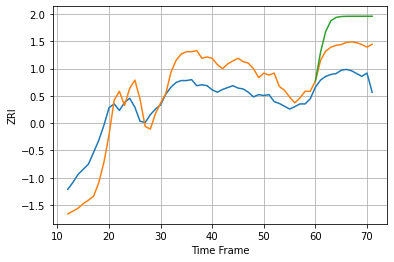

11378 51.933662454822084 61.17619845387863 113.14464300963418


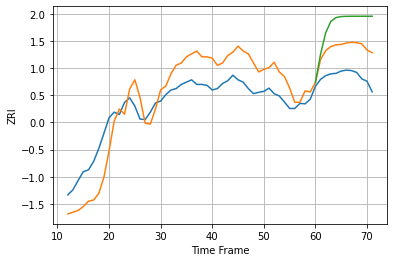

11379 53.42620312142287 60.77883435327061 115.57095403464426


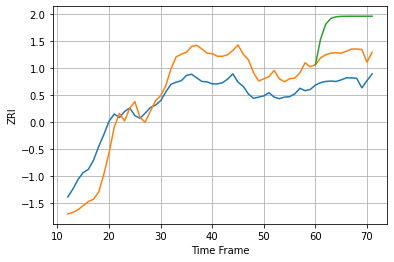

11385 60.83766532127165 67.32322337315107 147.1237996203839


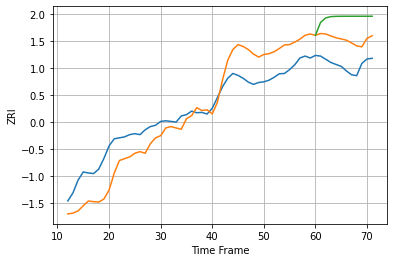

11412 71.58582419552242 79.1142665832439 144.45674880681375


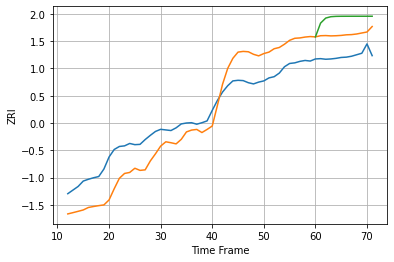

11413 80.78163979200494 73.71996199216821 125.63721176585625


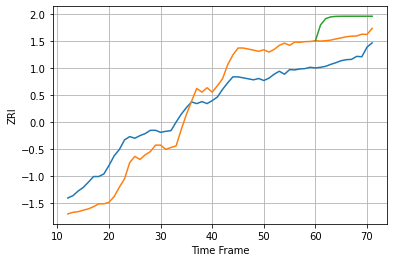

11414 73.52912962177888 68.3980157435259 123.18661979863279


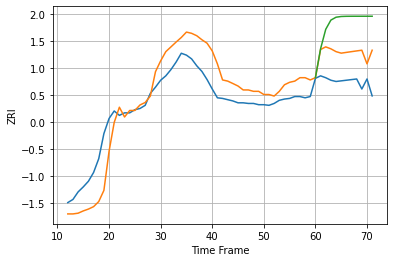

11415 34.9791155021793 47.04864124473368 94.93075142884872


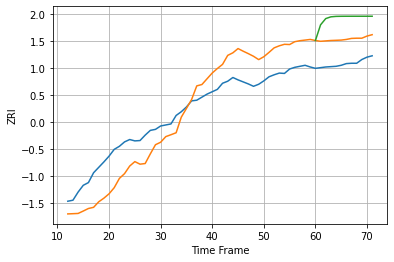

11416 72.58598731946059 72.8455887282379 132.20461464871715


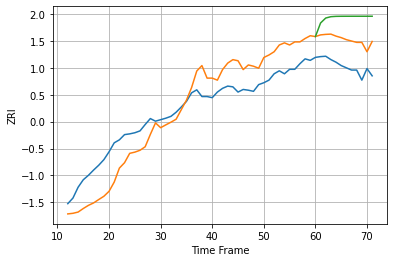

11417 62.365868823703586 72.49986113673579 129.93620853916062


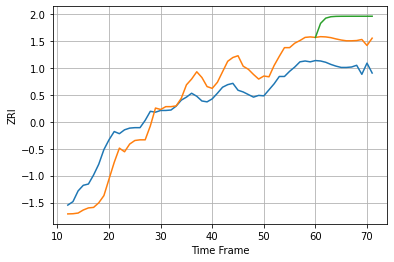

11418 50.35536212257226 62.70468744088078 111.63544915341566


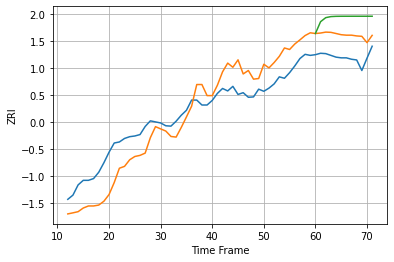

11419 63.48653942043685 64.2943725473223 112.25612261446366


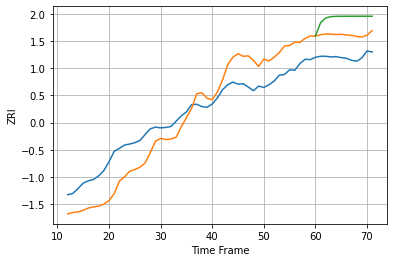

11420 71.82284341001979 66.87651665824698 116.78919545131474


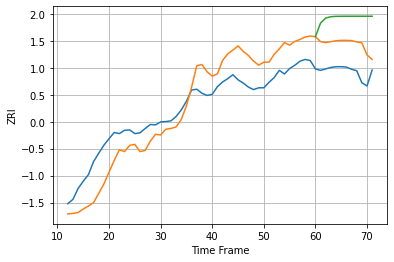

11421 64.60646135803208 77.92788267857753 146.57584489862853


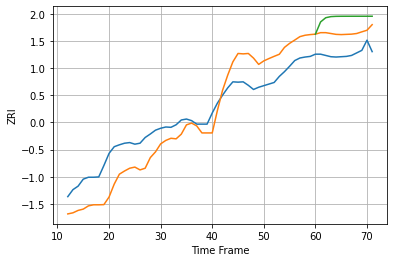

11422 74.16770570883132 66.76953918631625 112.09387845417459


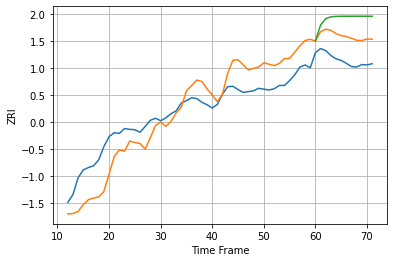

11423 54.38180097996288 58.20121817842516 102.58916805176534


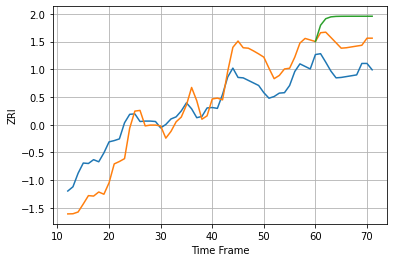

11426 55.86210641008639 65.278426389381 120.43802466868478


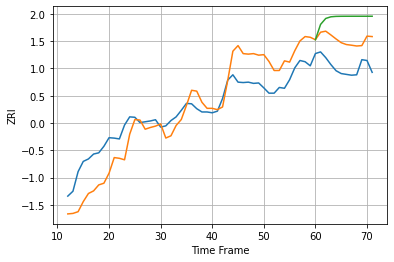

11427 56.03655580803741 66.32277001751959 118.82040009455562


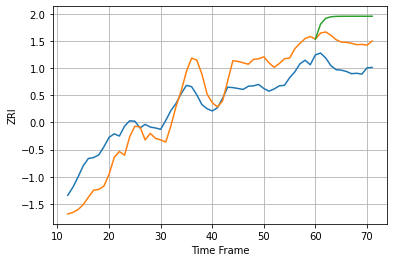

11428 52.81866349255741 59.79434473682847 109.64527831412406


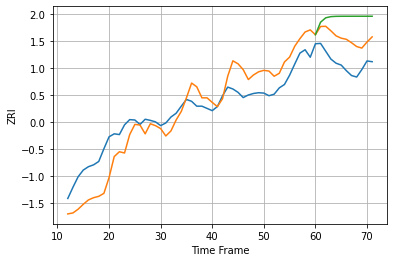

11429 56.34094049687577 67.73175895755557 122.42466336597832


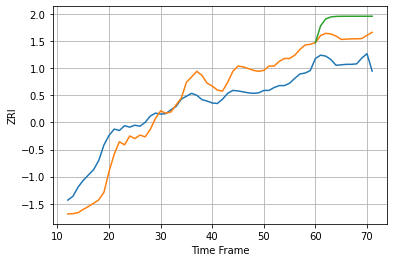

11432 45.197218045922284 51.523959961572075 88.8095930083634


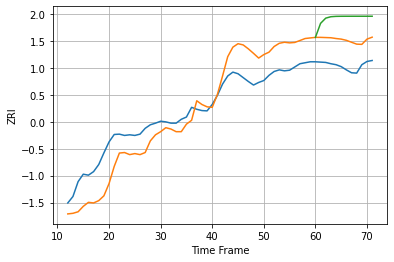

11433 71.48300840422047 80.15453298893893 146.2985804565284


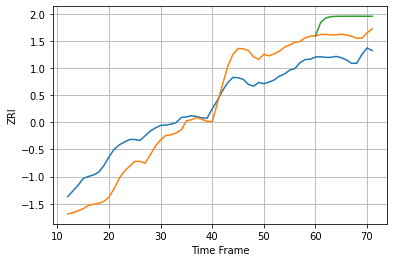

11434 75.82804228889219 70.90985822941776 123.9235487786024


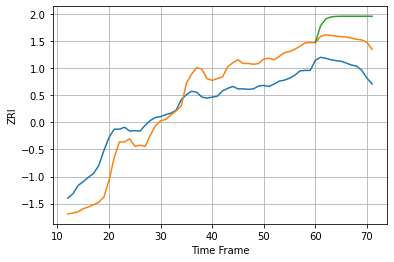

11435 47.9166878452351 55.196648713523075 97.8396161955612


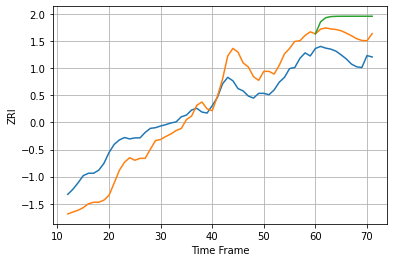

11436 66.59129863535168 66.55328658731446 114.00645367062833


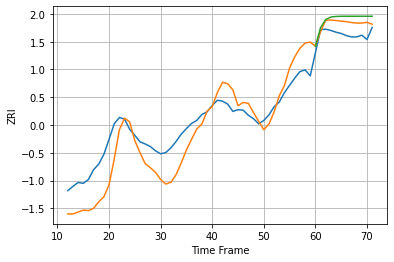

11542 52.4301171522986 26.74577660000578 37.675899043944675


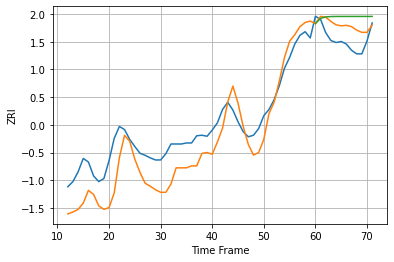

11550 48.27332777760029 31.882428680651273 48.631089772003136


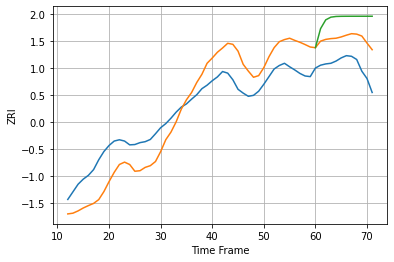

11561 79.97453751214742 86.60112241682552 150.23349504740685


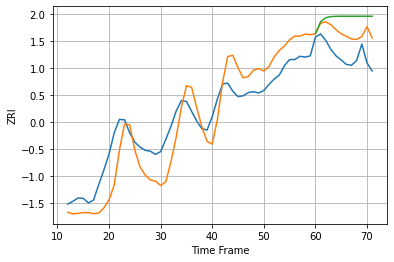

11563 59.135193899333316 58.52969312027406 94.66218149483694


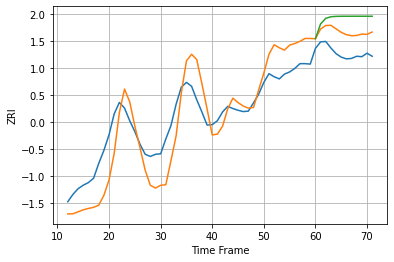

11580 57.436274269096614 47.9857935331998 80.58236835860977


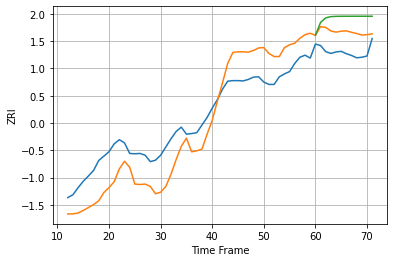

11590 91.64490317817001 69.41801100180334 116.9177246002661


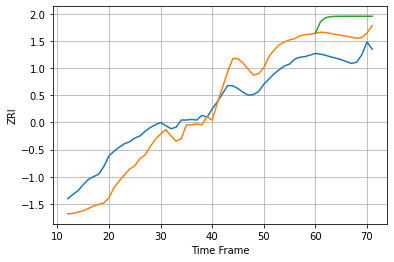

11691 71.95279442667312 71.57637359848566 123.74924449426959


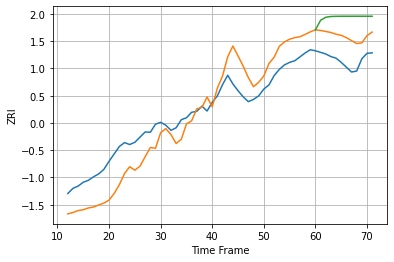

11692 71.40661259210272 74.53002869835139 131.43615535472657


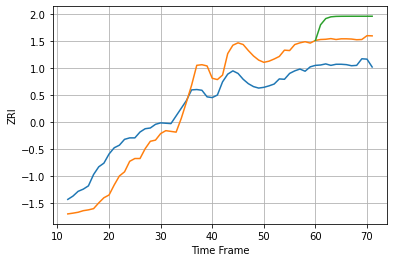

11694 67.44679197301092 69.55918130504458 123.83398851597082


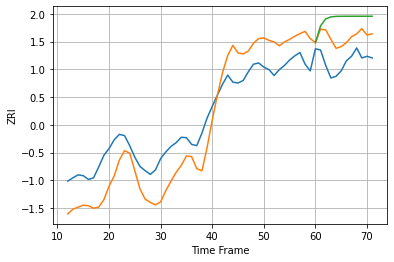

11758 67.64671913439173 59.49669619939908 104.32881505896829


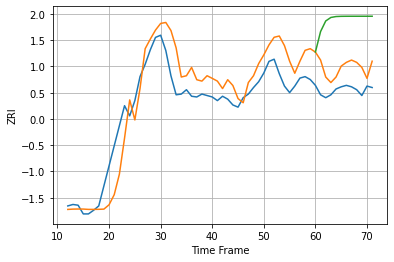

12047 32.01514931176878 33.246296639101864 96.19880082910691


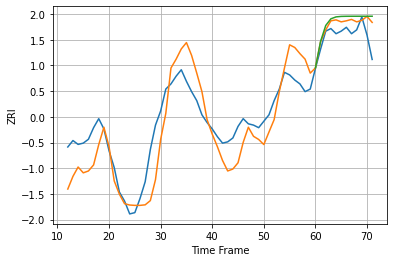

12180 19.52822589025546 11.066236438857308 13.305116515454028


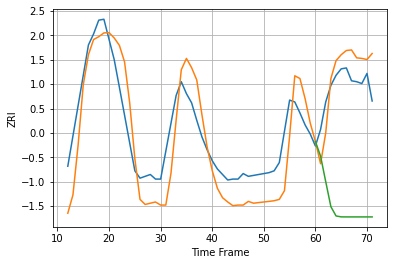

12182 33.78653768788438 27.243989944894444 131.20261278102726


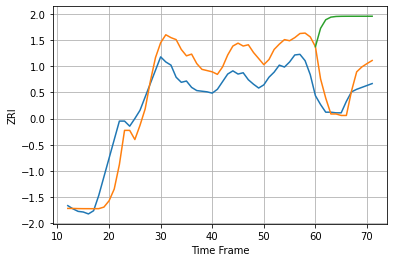

12189 38.25255480189719 32.73653529823135 126.06346118305272


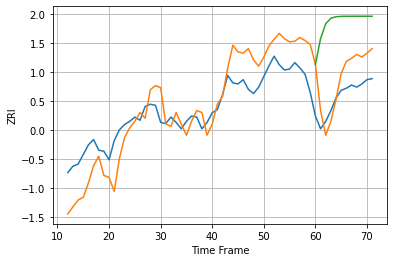

12202 23.900666297897974 24.79134465661955 70.66007457958169


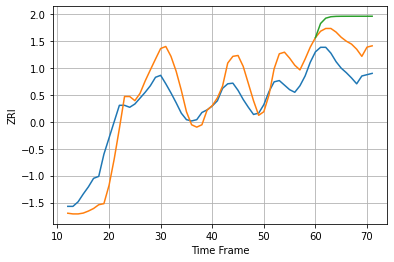

12203 34.648209407597804 40.80628354617204 76.06159884424129


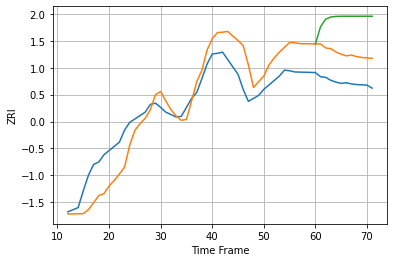

12206 38.95610087660239 48.63724168737783 105.19676335355534


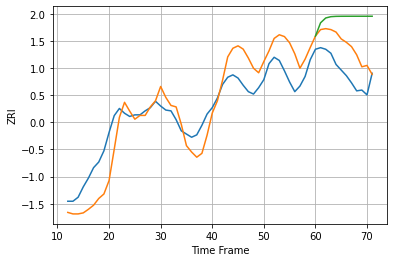

12208 28.73525325509424 33.536628617213516 69.16781057616889


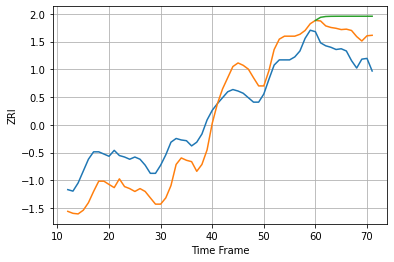

12209 35.78097328879033 31.87987871565984 51.115248155925855


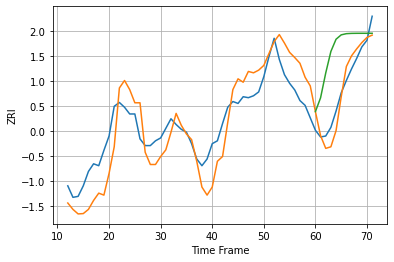

12210 26.158920256298025 13.862910586228661 47.40674434609331


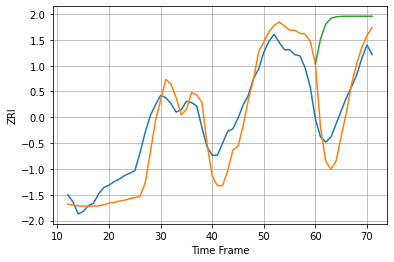

12303 18.864883271581647 21.383672866223428 68.29338791750025


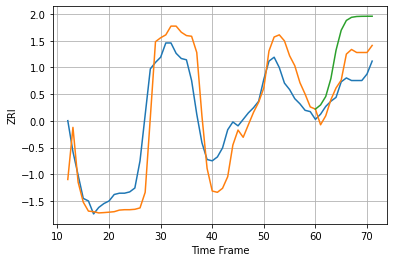

12304 22.244130995091368 14.468274740959048 36.331966215578554


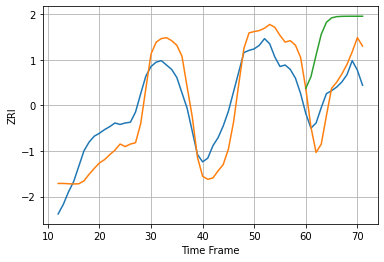

12306 34.54172346485564 30.936091601359653 84.37240035420879


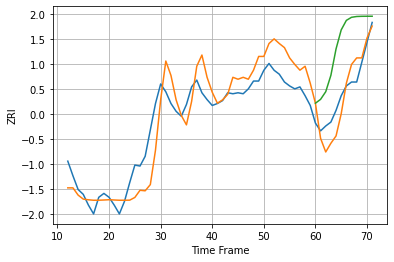

12307 22.40399958626386 17.47710665643046 49.842623382500406


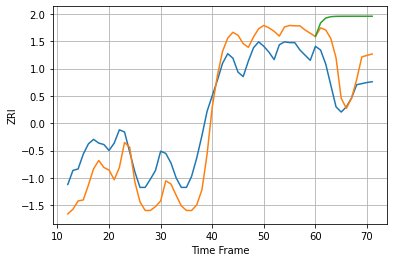

12401 37.619523985982646 36.622092001370255 94.00151184556094


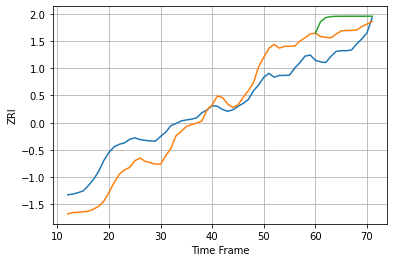

12508 60.93739472353105 52.71607163289422 89.2287983891211


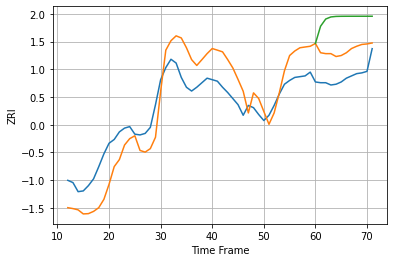

12550 34.044616584670656 37.020060887064254 76.55094644476038


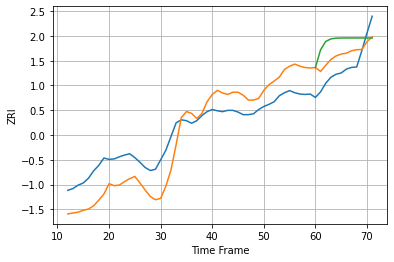

12590 54.91068393979672 42.36139821768426 72.79143166838675


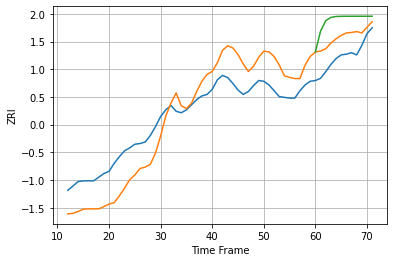

12601 35.30776803424126 27.718627221521185 50.89145200430143


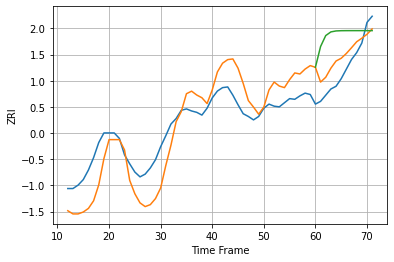

12603 35.62772052060178 27.772021991247655 59.124320897673115


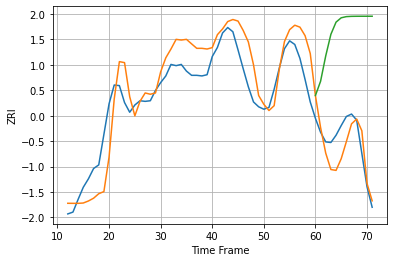

12866 41.377609322752924 33.81334343959416 191.56033613023735


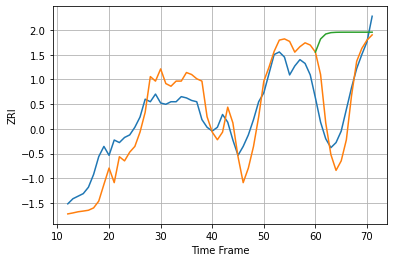

13203 17.618193800980436 19.917436939060767 58.278315198264195


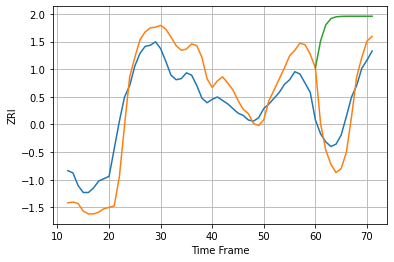

13204 22.695194776229396 21.831003453585275 78.88162740876439


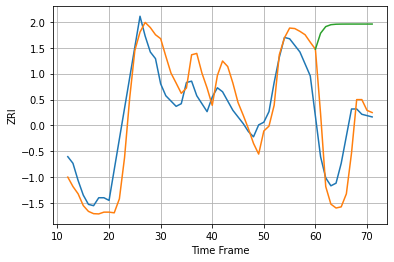

13205 18.49518952876389 26.58287579530499 88.60485707133081


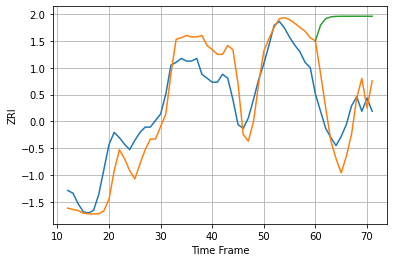

13206 18.750361971229314 21.934606692465884 75.37457953464464


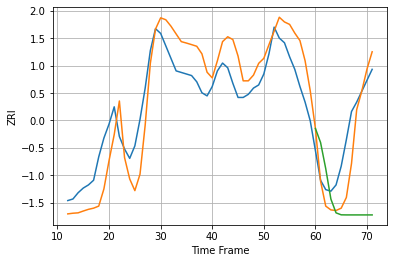

13208 18.994645893230075 18.53177764344293 55.212622463975194


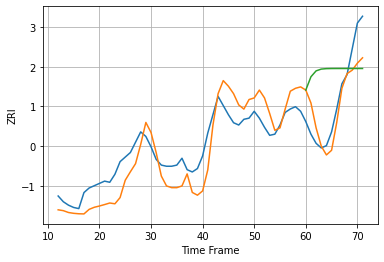

13440 17.915040424438942 20.51454222928613 45.649628954222095


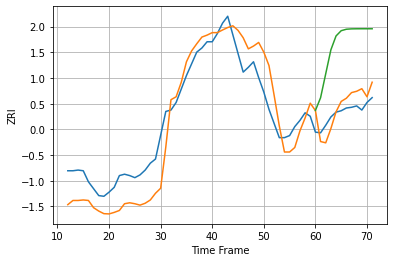

13501 35.38811684970374 20.182158649840673 99.17109623271864


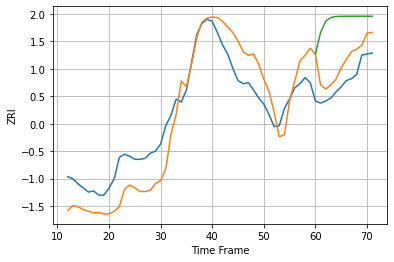

13502 25.74588030316181 22.168067790135016 60.83283848776475


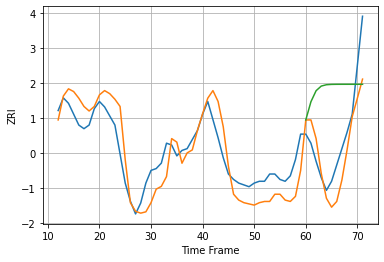

13601 11.754450759498978 15.666371566594849 37.21954341437103


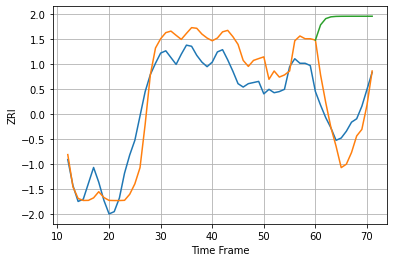

13760 20.660821687400833 22.49019075762927 85.65680024181184


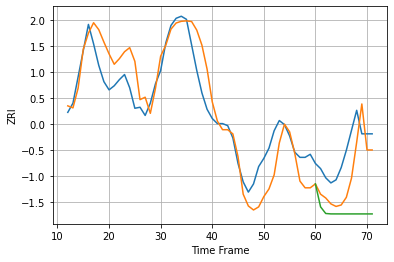

13903 23.706744087913194 29.557014292490308 62.15071051502319


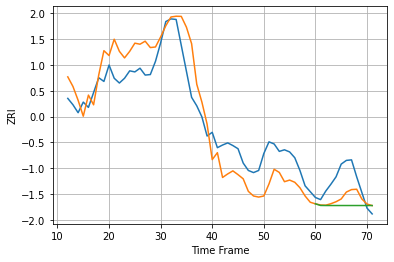

14020 46.77421060174467 37.157711934947976 50.119248555661635


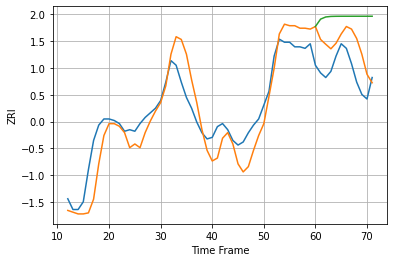

14043 14.059527275075823 19.11297489064876 36.544600397560686


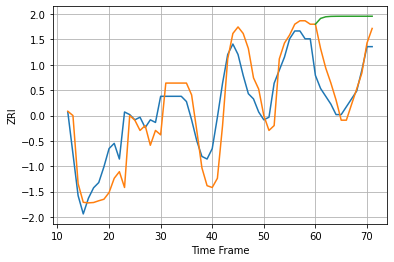

14150 10.04302047177365 8.7514111388147 28.437531311634988


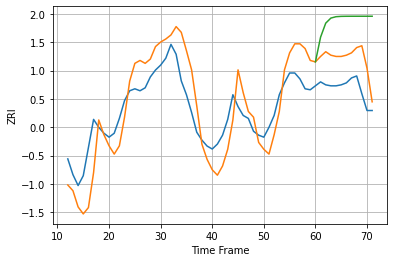

14201 27.534428001769218 31.083200009062658 69.21269111953474


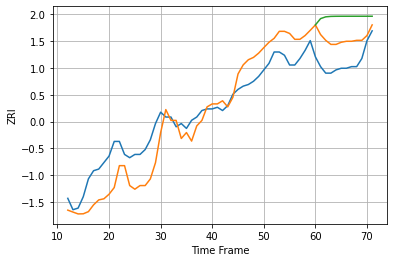

14206 14.036743080691519 15.611154212746085 28.44927934368531


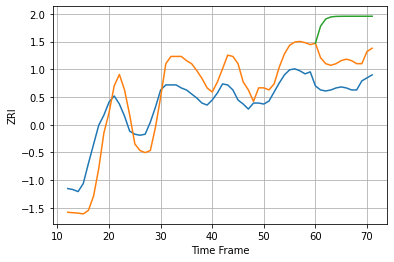

14207 24.809875046220863 28.065914725554407 66.6257629013408


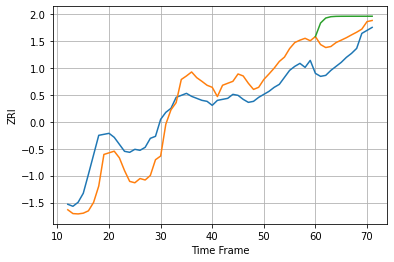

14208 22.821778376924346 22.19411105778239 40.56777345152536


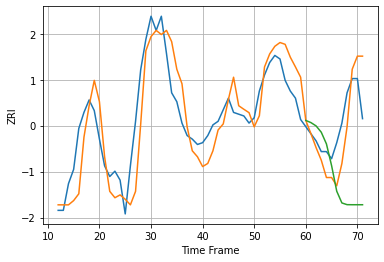

14209 15.522823696343968 16.47117167096924 40.15166225856742


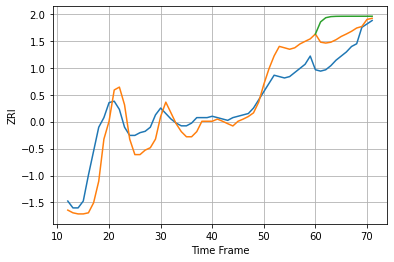

14210 14.043329122767675 14.937773593620625 26.24912848967453


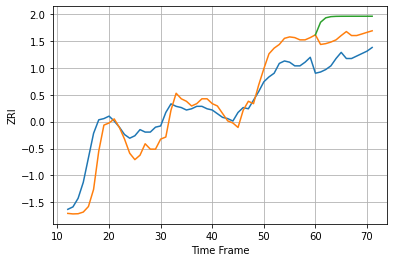

14211 15.414398621422267 19.401919281618074 34.017864891176885


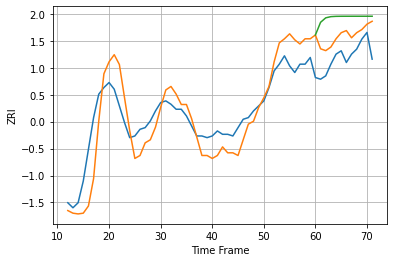

14212 13.475325813290171 14.851959463066015 24.79975318668351


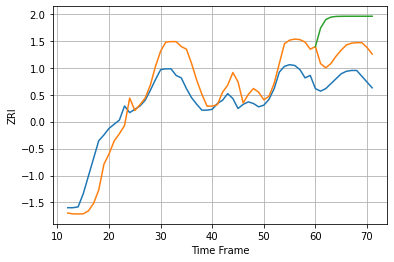

14213 26.65560813460259 35.111395765255324 73.30807832563337


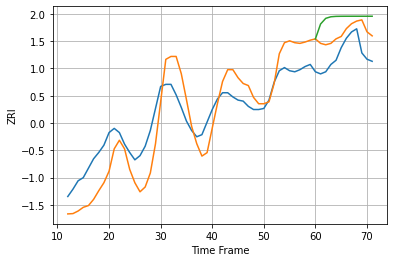

14214 24.39069418000683 22.172712634510436 36.66616072714029


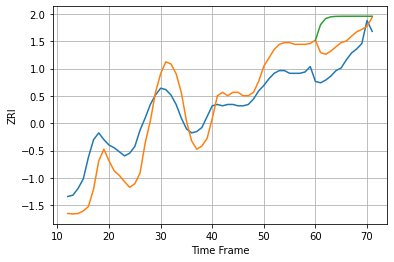

14215 17.863715544627496 17.15457089174006 32.549941162322824


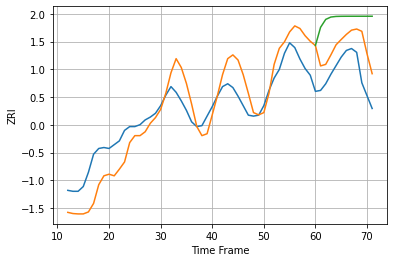

14216 24.255476082528258 31.74819075309258 60.92753109044006


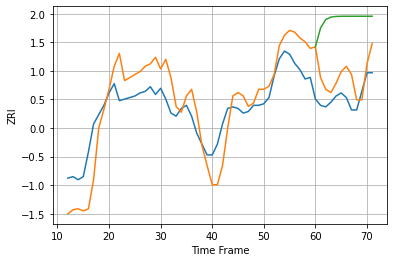

14217 17.0360737493359 16.498697288410128 49.97765903884097


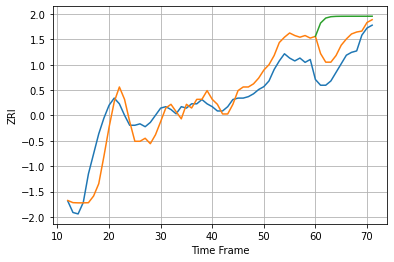

14218 12.308007222122612 14.854292787750593 31.515170812573096


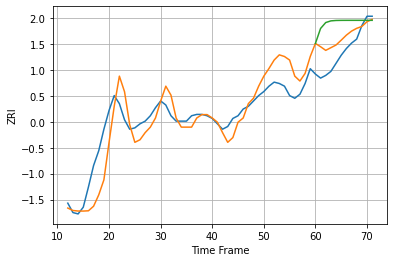

14220 14.031902150323662 13.833156344657763 24.96913653620942


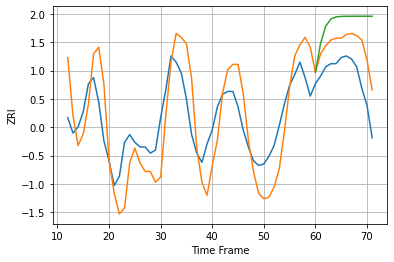

14221 22.138713645868638 19.998058350456684 38.61661482383349


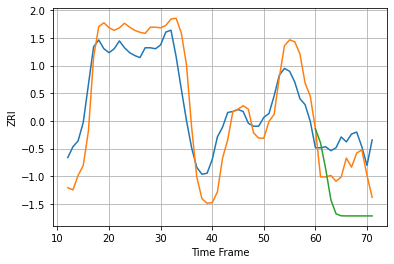

14222 28.699174135570956 30.418418901951117 63.31468493543945


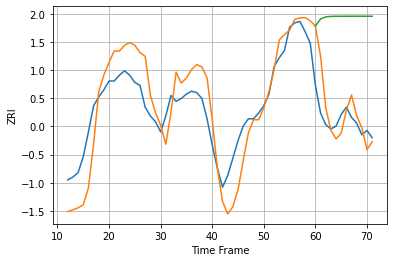

14224 18.796327898279472 18.350129387828506 71.60497104824896


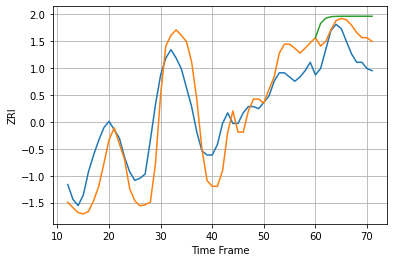

14225 13.256594885282853 11.181115881087786 17.754917647863085


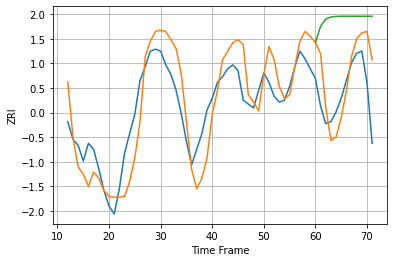

14228 14.089723215704247 18.59339887504966 40.27006463917298


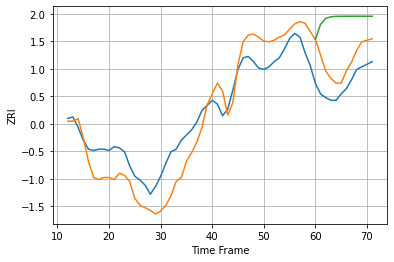

14301 18.263766953778074 19.751725611727068 51.20188632624425


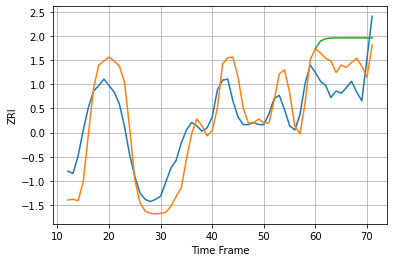

14607 23.183411063690105 25.072974828291066 42.9086985250532


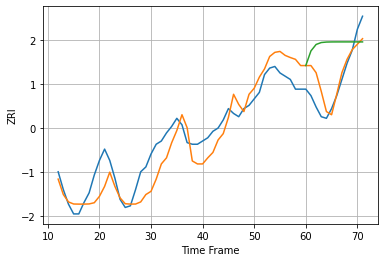

14609 11.644298781088628 11.479214217409176 29.740585712508793


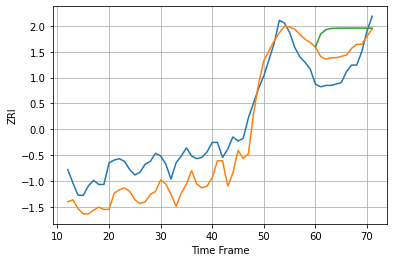

14611 19.370170066477467 16.997507286953393 31.515221798389735


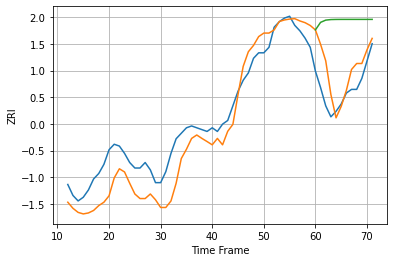

14613 12.383408713718973 13.754661466211056 38.475619899803384


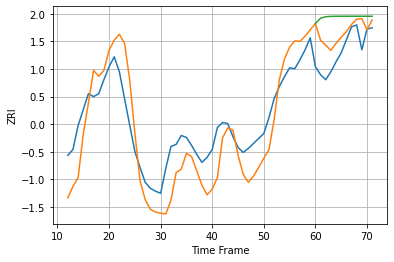

14620 28.428707261079886 23.252822430595756 38.53566952177133


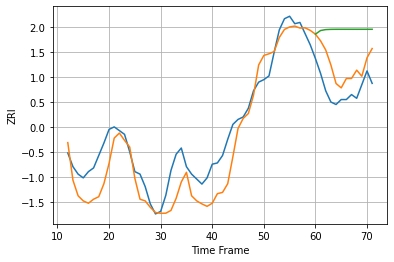

14621 18.349576659768424 21.058336361478503 48.57106237180838


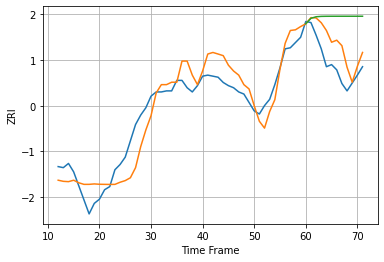

14701 17.009595626301675 21.220895708800942 47.347741519239754


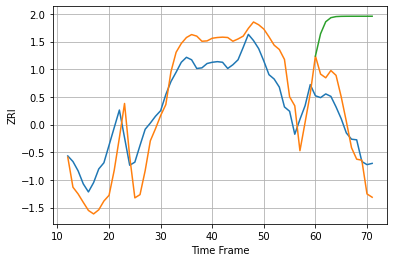

14850 44.70548563307312 39.27036218816141 176.89181419363481


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_2:
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis, np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]),
      sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

230 47.34579440839197 117.65053097004485


In [16]:
test = pd.DataFrame(score_dict)
test.to_csv('NN_2_batch.csv', index = False)

In [17]:
# NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [18]:
# NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [19]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')